![SSS logo](images/facebook_cover_photo_2.png)

# Business Case

Sam Samson and Sons is a real estate developer looking to adopt a data driven approach to choosing which properties to acquire, remodel, and bring back to market. In particular they want a model to answer the following questions:

1. Which upgrades will yield the highest return?
   - Examples:
     - what is the value of adding living space to the home?
     - what is the value of adding a bedroom or a bathroom?

# The Data
The data for this analysis was given to us by the client.  The dataset contains approximately one year of sales data from 05/02/2014, 05/27/2015.

## Column Names and descriptions for Kings County Data Set

**Updated from [https://www.kaggle.com/harlfoxem/housesalesprediction/discussion/207885]**
* **id** - unique identified for a house
* **dateDate** - house was sold
* **pricePrice** -  is prediction target
* **bedroomsNumber** -  of Bedrooms/House
* **bathroomsNumber** -  of bathrooms/bedrooms
* **sqft_livingsquare** -  footage of the home
* **sqft_lotsquare** -  footage of the lot
* **floorsTotal** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - An index from 0 to 4 of how good the view of the property was
* **condition** - How good the condition is ( Overall )
* **grade** - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design.
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors


# Scrub (Data Preparation)

This section contains all of the basic data cleaning for the data set including:
* Fixing and understanding datatypes including Categorical vs Continuous
* Identifying and dealing with missing data

## Get Data

In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
import seaborn as sns
%matplotlib inline

import scipy.stats as stats

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols

from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.cluster import DBSCAN
import sklearn.preprocessing as preprocessing

import folium
import json
import patsy


#from scipy.stats import shapiro

from IPython.core.display import HTML


In [2]:
# settings
pd.options.display.max_columns = 100
pd.options.display.max_columns = 100

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.rcParams["figure.figsize"] = (9,6)

In [3]:
# get data
df = pd.read_csv('data/kc_house_data.csv', index_col='id')
df.head(2)

date     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
id                                                                             
7129300520  10/13/2014  221900.0         3       1.00         1180      5650   
6414100192   12/9/2014  538000.0         3       2.25         2570      7242   

            floors  waterfront  view  condition  grade  sqft_above  \
id                                                                   
7129300520     1.0         NaN   0.0          3      7        1180   
6414100192     2.0         0.0   0.0          3      7        2170   

           sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
id                                                                            
7129300520           0.0      1955           0.0    98178  47.5112 -122.257   
6414100192         400.0      1951        1991.0    98125  47.7210 -122.319   

            sqft_living15  sqft_lot15  
id                                     
7129300520           1340        5650  
6414100192           1690        7639

In [4]:
# number of records
len(df)

21597

In [5]:
# Show date range

date = pd.to_datetime(df['date'])
date = date.sort_values()
date.iloc[0], date.iloc[-1]


(Timestamp('2014-05-02 00:00:00'), Timestamp('2015-05-27 00:00:00'))

We have 21597 records of home sales data spanning May 02, 2014 - May 27, 2015

## Drop Duplicates

Check to see if there are houses listed more than once and if so drop them.

In [6]:
# number of duplicated rows
df.duplicated().sum()

0

In [7]:
# number of duplicated ids
df.index.duplicated().sum()

177

In [8]:
# look at the duplicated ids
df[df.index.duplicated(keep=False)].head()

date      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
id                                                                              
6021501535   7/25/2014   430000.0         3       1.50         1580      5000   
6021501535  12/23/2014   700000.0         3       1.50         1580      5000   
4139480200   6/18/2014  1380000.0         4       3.25         4290     12103   
4139480200   12/9/2014  1400000.0         4       3.25         4290     12103   
7520000520    9/5/2014   232000.0         2       1.00         1240     12092   

            floors  waterfront  view  condition  grade  sqft_above  \
id                                                                   
6021501535     1.0         0.0   0.0          3      8        1290   
6021501535     1.0         0.0   0.0          3      8        1290   
4139480200     1.0         0.0   3.0          3     11        2690   
4139480200     1.0         0.0   3.0          3     11        2690   
7520000520     1.0         NaN   0.0          3      6         960   

           sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
id                                                                            
6021501535         290.0      1939           0.0    98117  47.6870 -122.386   
6021501535         290.0      1939           0.0    98117  47.6870 -122.386   
4139480200        1600.0      1997           0.0    98006  47.5503 -122.102   
4139480200        1600.0      1997           0.0    98006  47.5503 -122.102   
7520000520         280.0      1922        1984.0    98146  47.4957 -122.352   

            sqft_living15  sqft_lot15  
id                                     
6021501535           1570        4500  
6021501535           1570        4500  
4139480200           3860       11244  
4139480200           3860       11244  
7520000520           1820        7460

Because these houses have the same characteristics but sold twice in a year we are going to drop the first one with the assumption that the second reflects a more current view of the market.

In [9]:
# Duplicates are houses that sold twice in a year.  Drop the first.
df1 = df[~df.index.duplicated(keep='last')].copy()
df1.head()

date     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
id                                                                             
7129300520  10/13/2014  221900.0         3       1.00         1180      5650   
6414100192   12/9/2014  538000.0         3       2.25         2570      7242   
5631500400   2/25/2015  180000.0         2       1.00          770     10000   
2487200875   12/9/2014  604000.0         4       3.00         1960      5000   
1954400510   2/18/2015  510000.0         3       2.00         1680      8080   

            floors  waterfront  view  condition  grade  sqft_above  \
id                                                                   
7129300520     1.0         NaN   0.0          3      7        1180   
6414100192     2.0         0.0   0.0          3      7        2170   
5631500400     1.0         0.0   0.0          3      6         770   
2487200875     1.0         0.0   0.0          5      7        1050   
1954400510     1.0         0.0   0.0          3      8        1680   

           sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
id                                                                            
7129300520           0.0      1955           0.0    98178  47.5112 -122.257   
6414100192         400.0      1951        1991.0    98125  47.7210 -122.319   
5631500400           0.0      1933           NaN    98028  47.7379 -122.233   
2487200875         910.0      1965           0.0    98136  47.5208 -122.393   
1954400510           0.0      1987           0.0    98074  47.6168 -122.045   

            sqft_living15  sqft_lot15  
id                                     
7129300520           1340        5650  
6414100192           1690        7639  
5631500400           2720        8062  
2487200875           1360        5000  
1954400510           1800        7503

In [10]:
# number of records remaining
len(df1)

21420

## missing values

In [11]:
# check for missing values by row
df1.isna().sum()

date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2353
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3813
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

#### waterfront

In [12]:
# waterfront unique values and counts
df1.waterfront.value_counts(normalize=True)

0.0    0.992343
1.0    0.007657
Name: waterfront, dtype: float64

For waterfront there are only two possible values, so missing values must mean we don't know.  Because 99% of the data is 0 we can fill the missing values with 0 (which is also the median) 

In [13]:
# Fill waterfront Nan with 0 (the median)
df1['waterfront'] = df1['waterfront'].fillna(0)

In [14]:
# recheck the number of missing values
df1['waterfront'].isna().sum()

0

#### view

In [15]:
# check the unique values for view
df1.view.value_counts(normalize=True)

0.0    0.901484
2.0    0.044763
3.0    0.023646
1.0    0.015405
4.0    0.014702
Name: view, dtype: float64

In [16]:
# get number of missing values for view
df1.view.isna().sum()

63

90% of the records have 0 for view.  We can safely fill the 63 missing values with 0 (the median)

In [17]:
# Fill with 0 which is far more than half the values
df1['view'] = df1['view'].fillna(0)

In [18]:
# check the number of missing values
df1['view'].isna().sum()

0

#### yr_renovated

In [19]:
#look at the most common values in yr_renovate
df1['yr_renovated'].value_counts(normalize=True).head()

0.0       0.957971
2014.0    0.004146
2003.0    0.001761
2013.0    0.001761
2007.0    0.001704
Name: yr_renovated, dtype: float64

In [20]:
# Check how many missing records there are in yr_renovated
df1['yr_renovated'].isna().sum()

3813

In [21]:
# check the median
df1['yr_renovated'].median()

0.0

The missing values here seem to indicate that we don't know if the house was ever renovated. 0 looks like it means the house was never renovated.  Although the data is missing more than 10% of the records, we can still fill with 0 (the median) because 96% of the data is 0.

In [22]:
# fill missing values with 0
df1['yr_renovated'] = df1['yr_renovated'].fillna(0)

In [23]:
# check for missing values
df1['yr_renovated'].isna().sum()

0

### Recheck Nan values

In [24]:
df1.isna().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

## Dtypes

In [25]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 7129300520 to 1523300157
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21420 non-null  object 
 1   price          21420 non-null  float64
 2   bedrooms       21420 non-null  int64  
 3   bathrooms      21420 non-null  float64
 4   sqft_living    21420 non-null  int64  
 5   sqft_lot       21420 non-null  int64  
 6   floors         21420 non-null  float64
 7   waterfront     21420 non-null  float64
 8   view           21420 non-null  float64
 9   condition      21420 non-null  int64  
 10  grade          21420 non-null  int64  
 11  sqft_above     21420 non-null  int64  
 12  sqft_basement  21420 non-null  object 
 13  yr_built       21420 non-null  int64  
 14  yr_renovated   21420 non-null  float64
 15  zipcode        21420 non-null  int64  
 16  lat            21420 non-null  float64
 17  long           21420 non-null  float

### Drop date
Date is not usable in an obvious way to answer our stakeholders questions.  If necessary we can try to see if it improves one of our final models.  For now drop it.

In [26]:
# drop date

df1.drop(columns=['date'], inplace=True)

### sqft_basement

In [27]:
# why is the dtype object
df1['sqft_basement'].value_counts(normalize = True).head()

0.0      0.593651
?        0.021102
600.0    0.010084
700.0    0.009617
500.0    0.009617
Name: sqft_basement, dtype: float64

The `?` indicates that we don't know the size of the basement or if there is one.  But our data contains `sqft_above` and `sqft_livng` for which the difference should be basement size.  We will try to infer basement size from these columns.

In [28]:
# Infer value from other columns
df1['sqft_basement'] = df1.apply(lambda x: x['sqft_living'] 
                                 - x['sqft_above'] if x['sqft_basement'] 
                                 == '?' else x['sqft_basement'], axis = 1)

df1[df1['sqft_basement'] == '?']

Empty DataFrame
Columns: [price, bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, condition, grade, sqft_above, sqft_basement, yr_built, yr_renovated, zipcode, lat, long, sqft_living15, sqft_lot15]
Index: []

In [29]:
# convert to int
df1['sqft_basement'] = df1['sqft_basement'].astype(float).astype(int)

In [30]:
# Check whether the values of sqft_basement are now equal to living - above

# count the rows where they are not equal
print((df1['sqft_basement'] != (df1['sqft_living'] - df1['sqft_above'])).sum())

0


Text(0.5, 1.0, 'Assesment of basement size from sqft_livng and sqft_above')

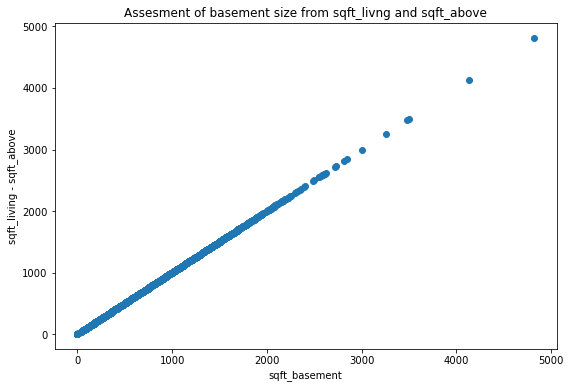

In [31]:
# visualize it 
plt.scatter(df1['sqft_basement'], (df1['sqft_living'] - df1['sqft_above']))
plt.ylabel('sqft_living - sqft_above')
plt.xlabel('sqft_basement')
plt.title('Assesment of basement size from sqft_livng and sqft_above')

In [32]:
# recheck value counts
df1['sqft_basement'].value_counts(normalize=True).head()

0      0.606863
600    0.010271
700    0.010037
500    0.009851
800    0.009617
Name: sqft_basement, dtype: float64

# Baseline Model

In [33]:
# create and examine a baseline model
X = df1.drop('price', axis=1)
y = df1['price']

model = sm.OLS(y, sm.add_constant(X)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     2933.
Date:                Mon, 18 Jan 2021   Prob (F-statistic):               0.00
Time:                        16:31:11   Log-Likelihood:            -2.9200e+05
No. Observations:               21420   AIC:                         5.840e+05
Df Residuals:                   21402   BIC:                         5.842e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          6.553e+06   2.95e+06      2.223      0.026    7.75e+05    1.23e+07
bedrooms      -3.593e+04   1914.019    -18.770      0.000   -3.97e+04   -3.22e+04
bathrooms      4.211e+04   3281.336     12.833      0.000    3.57e+04    4.85e+04
sqft_living     110.2520      2.286     48.220      0.000     105.770     114.734
sqft_lot          0.1270      0.048      2.645      0.008       0.033       0.221
floors         6728.6995   3614.137      1.862      0.063    -355.280    1.38e+04
waterfront     6.182e+05   1.82e+04     34.026      0.000    5.83e+05    6.54e+05
view           5.316e+04   2131.691     24.937      0.000     4.9e+04    5.73e+04
condition      2.653e+04   2364.666     11.218      0.000    2.19e+04    3.12e+04
grade          9.694e+04   2172.121     44.628      0.000    9.27e+04    1.01e+05
sqft_above       70.5989      2.264     31.189      0.000      66.162      75.036
sqft_basement    39.6631      2.660     14.909      0.000      34.448      44.878
yr_built      -2650.8640     72.306    -36.662      0.000   -2792.590   -2509.138
yr_renovated     23.4645      3.995      5.874      0.000      15.635      31.294
zipcode        -583.9461     33.193    -17.593      0.000    -649.006    -518.886
lat            6.018e+05   1.08e+04     55.777      0.000    5.81e+05    6.23e+05
long          -2.179e+05   1.32e+04    -16.477      0.000   -2.44e+05   -1.92e+05
sqft_living15    21.1244      3.464      6.098      0.000      14.334      27.915
sqft_lot15       -0.3888      0.073     -5.289      0.000      -0.533      -0.245
==============================================================================
Omnibus:                    18222.326   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1828034.227
Skew:                           3.571   Prob(JB):                         0.00
Kurtosis:                      47.690   Cond. No.                     1.42e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.07e-20. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

The model looks fairly good to begin with.  The $R^2$ of 0.7 indicates reasonable predictive power and none of the pvalues are above 0.05.

# Tools

This section contains tools for repetitive tasks and model iteration tracking.

In [34]:

# scorer function to calculate mse on the origina sclae for log transformed dv
def mse_delogged(y_true, y_pred):
    resid = np.exp(y_true) - np.exp(y_pred)
    mse = (resid ** 2).mean()
    return mse

# a function for running a cross validation
def cross_validate_rmse(X, y, cv=5, delog_y=False):
    '''Returnes Test RMSE, Train RMSE, and the differene between the two
    
Parameters
----------
X: Pandas DataFrame    
    Indepnendent variables

y: One column pandas DataFrame
    Dependent Variable
    
cv : int, cross-validation generator or an iterable, default=None
    Determines the cross-validation splitting strategy.
    Possible inputs for cv are:

    - None, to use the default 5-fold cross validation,
    - int, to specify the number of folds in a `(Stratified)KFold`,
    - :term:`CV splitter`,
    - An iterable yielding (train, test) splits as arrays of indices.

    For int/None inputs, if the estimator is a classifier and ``y`` is
    either binary or multiclass, :class:`StratifiedKFold` is used. In all
    other cases, :class:`KFold` is used.

    Refer :ref:`User Guide <cross_validation>` for the various
    cross-validation strategies that can be used here.
    
delog_y: Bool
    If y has been log transformed, True will return results in original units, 
    False will return in percentages.
    
Returns
-------
    tuple: (RMSE on training data, RMSE on testing data, difference between
    the two)'''


    # choose scorer
    if delog_y:
        mse = make_scorer(mse_delogged)        
    else:
        mse = make_scorer(mean_squared_error)
    
    # run cross validation returing both testing and training scores.
    linreg = LinearRegression()    
    cvs = cross_validate(linreg, X, y, cv=5,    
                          scoring=mse, return_train_score=True)
    
    #convert mse to rmse
    train_rmse = np.sqrt(cvs['train_score']).mean()
    test_rmse= np.sqrt(cvs['test_score']).mean()
    
    return  train_rmse, test_rmse, test_rmse - train_rmse

In [35]:
## Test it on the baseline model
cross_validate_rmse(X, y)

(201244.6075293908, 202880.100750806, 1635.4932214152068)

In [36]:
# a quick way to run a model, perform crossfold validation, get the results
# and store a model for later comparison.

models = {}
def quicktest(X, y, name=None, display_summary=True, delog_rmse=False):
    
    # run cross validation
    if delog_rmse:
        rmses = cross_validate_rmse(X, y, delog_y=True)
    else:
        rmses = cross_validate_rmse(X, y)
    
    # create a model with all of the data for displaying summary info
    model = sm.OLS(y, sm.add_constant(X)).fit()
    
    if display_summary:
        display(model.summary())
    
    # generate short sumary
    summary = {'r2': round(model.rsquared, 3),
               'train_rmse': round(rmses[0]), 
               'test_rmse': round(rmses[1]), 
               'diff_rmse': round(rmses[2])}
    
    # store short summary if model name is specified
    if name is not None:
        models[name] = summary
    
    return summary
    

In [37]:
quicktest(X, y, name='baseline')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     2933.
Date:                Mon, 18 Jan 2021   Prob (F-statistic):               0.00
Time:                        16:31:16   Log-Likelihood:            -2.9200e+05
No. Observations:               21420   AIC:                         5.840e+05
Df Residuals:                   21402   BIC:                         5.842e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          6.553e+06   2.95e+06      2.223      0.026    7.75e+05    1.23e+07
bedrooms      -3.593e+04   1914.019    -18.770      0.000   -3.97e+04   -3.22e+04
bathrooms      4.211e+04   3281.336     12.833      0.000    3.57e+04    4.85e+04
sqft_living     110.2520      2.286     48.220      0.000     105.770     114.734
sqft_lot          0.1270      0.048      2.645      0.008       0.033       0.221
floors         6728.6995   3614.137      1.862      0.063    -355.280    1.38e+04
waterfront     6.182e+05   1.82e+04     34.026      0.000    5.83e+05    6.54e+05
view           5.316e+04   2131.691     24.937      0.000     4.9e+04    5.73e+04
condition      2.653e+04   2364.666     11.218      0.000    2.19e+04    3.12e+04
grade          9.694e+04   2172.121     44.628      0.000    9.27e+04    1.01e+05
sqft_above       70.5989      2.264     31.189      0.000      66.162      75.036
sqft_basement    39.6631      2.660     14.909      0.000      34.448      44.878
yr_built      -2650.8640     72.306    -36.662      0.000   -2792.590   -2509.138
yr_renovated     23.4645      3.995      5.874      0.000      15.635      31.294
zipcode        -583.9461     33.193    -17.593      0.000    -649.006    -518.886
lat            6.018e+05   1.08e+04     55.777      0.000    5.81e+05    6.23e+05
long          -2.179e+05   1.32e+04    -16.477      0.000   -2.44e+05   -1.92e+05
sqft_living15    21.1244      3.464      6.098      0.000      14.334      27.915
sqft_lot15       -0.3888      0.073     -5.289      0.000      -0.533      -0.245
==============================================================================
Omnibus:                    18222.326   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1828034.227
Skew:                           3.571   Prob(JB):                         0.00
Kurtosis:                      47.690   Cond. No.                     1.42e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.07e-20. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

{'r2': 0.7, 'train_rmse': 201245.0, 'test_rmse': 202880.0, 'diff_rmse': 1635.0}

In [38]:
# pretty print the models

def model_report():
    df = pd.DataFrame(models).T
    
    # FIX: ensure the correct order of columns
    df = df[['r2', 'train_rmse', 'test_rmse', 'diff_rmse']]
    
    return df

In [39]:
model_report()

r2  train_rmse  test_rmse  diff_rmse
baseline  0.7    201245.0   202880.0     1635.0

# Explore (Data Understanding)

In [40]:
df1.describe()

price      bedrooms     bathrooms   sqft_living      sqft_lot  \
count  2.142000e+04  21420.000000  21420.000000  21420.000000  2.142000e+04   
mean   5.418614e+05      3.373950      2.118429   2083.132633  1.512804e+04   
std    3.675569e+05      0.925405      0.768720    918.808412  4.153080e+04   
min    7.800000e+04      1.000000      0.500000    370.000000  5.200000e+02   
25%    3.249500e+05      3.000000      1.750000   1430.000000  5.040000e+03   
50%    4.505500e+05      3.000000      2.250000   1920.000000  7.614000e+03   
75%    6.450000e+05      4.000000      2.500000   2550.000000  1.069050e+04   
max    7.700000e+06     33.000000      8.000000  13540.000000  1.651359e+06   

             floors    waterfront          view     condition         grade  \
count  21420.000000  21420.000000  21420.000000  21420.000000  21420.000000   
mean       1.495985      0.006816      0.233987      3.410784      7.662792   
std        0.540081      0.082280      0.765437      0.650035      1.171971   
min        1.000000      0.000000      0.000000      1.000000      3.000000   
25%        1.000000      0.000000      0.000000      3.000000      7.000000   
50%        1.500000      0.000000      0.000000      3.000000      7.000000   
75%        2.000000      0.000000      0.000000      4.000000      8.000000   
max        3.500000      1.000000      4.000000      5.000000     13.000000   

         sqft_above  sqft_basement      yr_built  yr_renovated      zipcode  \
count  21420.000000   21420.000000  21420.000000  21420.000000  21420.00000   
mean    1791.170215     291.962418   1971.092997     68.956723  98077.87437   
std      828.692965     442.875502     29.387141    364.552298     53.47748   
min      370.000000       0.000000   1900.000000      0.000000  98001.00000   
25%     1200.000000       0.000000   1952.000000      0.000000  98033.00000   
50%     1560.000000       0.000000   1975.000000      0.000000  98065.00000   
75%     2220.000000     560.000000   1997.000000      0.000000  98117.00000   
max     9410.000000    4820.000000   2015.000000   2015.000000  98199.00000   

                lat          long  sqft_living15     sqft_lot15  
count  21420.000000  21420.000000   21420.000000   21420.000000  
mean      47.560197   -122.213784    1988.384080   12775.718161  
std        0.138589      0.140791     685.537057   27345.621867  
min       47.155900   -122.519000     399.000000     651.000000  
25%       47.471200   -122.328000    1490.000000    5100.000000  
50%       47.572100   -122.230000    1840.000000    7620.000000  
75%       47.678100   -122.125000    2370.000000   10086.250000  
max       47.777600   -121.315000    6210.000000  871200.000000

The price range is from 78k - 7m which is large but not unexpected.  There is a similarly large range for `sqft_living` 2 - 13.5k.  Bedrooms are in whole numbers, but bathrooms have decimals to indicate half baths.

## Linearity

In [41]:
#Create scatterplots for each col against the dv
def scatter_cols(df, dv):
    '''Takes a dataframe and a dependent variable and prints scatterplots of 
    each varible against the dependent variable'''
    
    cols = df.columns
    
    #calculate number of rows assuming 3 plots per row
    rows = len(cols) // 3 + bool(len(cols) % 3)
    
    
    # setup the plot
    fig, axs = plt.subplots(rows, 3, figsize=(12,rows*3))
    
    # flatten the axs variable so plots can be accessed sequentially
    axs = np.array(axs).flatten()

    # create plots
    for n, col in enumerate(cols):
        sns.scatterplot(x=df[col], y=dv, ax=axs[n])
        plt.xlabel(col)

    plt.tight_layout()

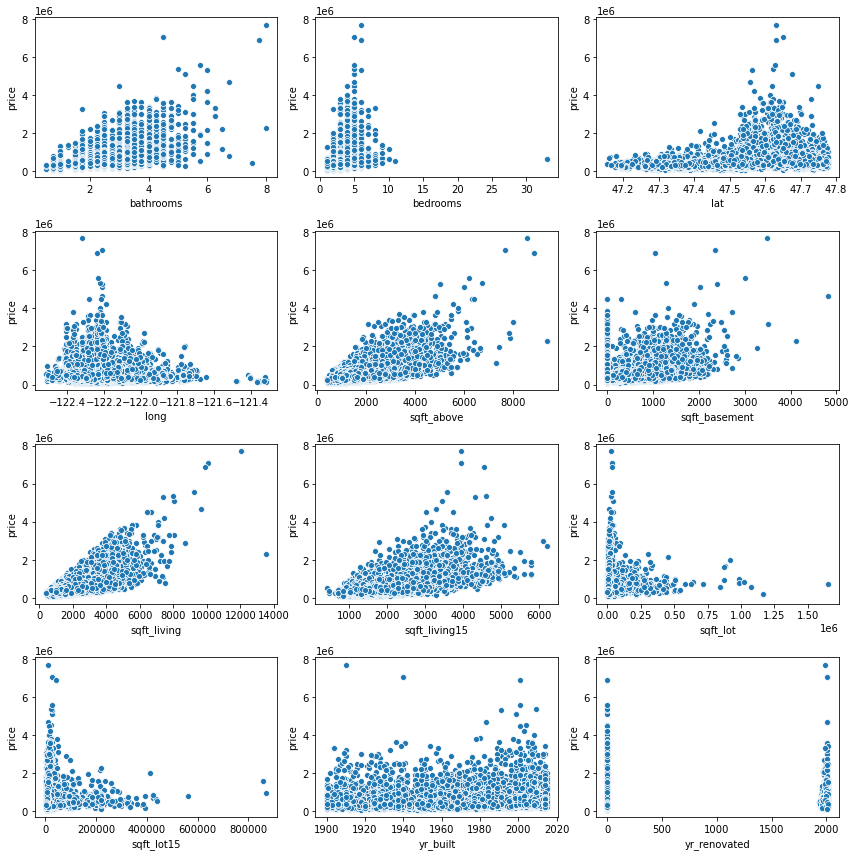

In [42]:
# create a set of suspected continuous variables
continuous = {'bedrooms', 'bathrooms', 'sqft_living',
                 'sqft_lot', 'sqft_above', 'sqft_basement',
                 'yr_built', 'yr_renovated', 'lat', 'long', 
                 'sqft_living15', 'sqft_lot15'}
                                
# plot continuous variables against the dependent variable
scatter_cols(df1[sorted(continuous)], df1['price'])

Most variables appear to have at least some linear relationship with price. The exceptions are `sqft_lot`, `sqft_lot15`, `lat` and `long`.  `sqft_lot` and `sqft_lot15` appear to extend in two directions.  Since our model already performs reasonably well we will drop them.

We are going to keep `lat` and `long` for now because they may be useful as geographic indicators later

`yr_renovated` looks like it has a large gap between 0 and the first non-zero value but then is linear.  This should be fine because any coefficient * 0 will be 0.

In [43]:
# drop variables that do not appear to have a linear relationship to price
df2 = df1.drop(columns=['sqft_lot', 'sqft_lot15'])

# remove from our continuouse var set so we can plot later
continuous.difference_update({'sqft_lot', 'sqft_lot15'})
continuous

{'bathrooms',
 'bedrooms',
 'lat',
 'long',
 'sqft_above',
 'sqft_basement',
 'sqft_living',
 'sqft_living15',
 'yr_built',
 'yr_renovated'}

In [44]:
# function to plot boxplots against the dependent variable
def boxplot_cols(df, dv):
    '''Takes a dataframe and a dependent variable and prints box plots of
    each varible agains the dependent variable'''
    
    cols = df.columns
    
    #calculate number of rows assuming 3 plots per row
    rows = len(cols) // 3 + bool(len(cols) % 3)
    
    fig, axs = plt.subplots(rows, 3, figsize=(12,rows*3))
    
    # flatten the axs variable so the can be accessed sequetially
    axs = np.array(axs).flatten()

    for n, col in enumerate(cols):
        sns.boxplot(x=df[col], y=dv, ax=axs[n])
        plt.xlabel(col)

    plt.tight_layout()

In [45]:
# set categoricals to everything not in continuous and not the dependent var
categoricals = set(df2.columns) - set(continuous) - {'price'}
categoricals

{'condition', 'floors', 'grade', 'view', 'waterfront', 'zipcode'}

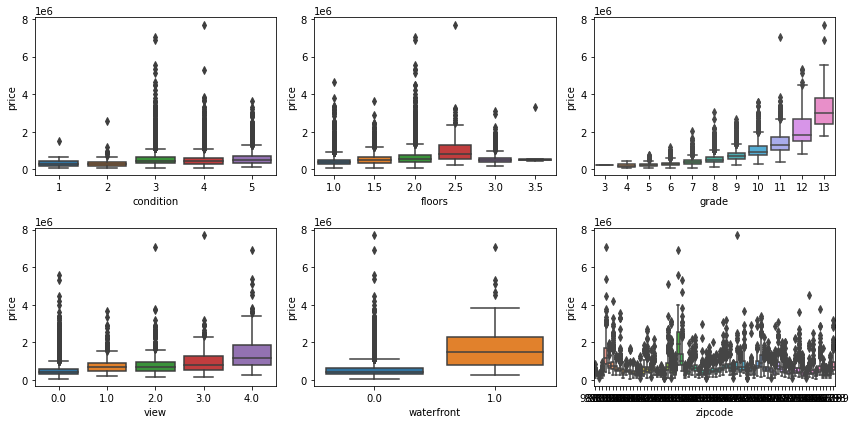

In [46]:
# plot the categorical vars against price
boxplot_cols(df2[sorted(categoricals)], df2['price'])

All of the potential categorical values except `zipcode` and `floors` appear to have a linear relationship with price.  Because of that we can treat them as continuous for now.

zipcodes are probably not being used correctly here which we will need to address soon.

In [47]:
# floors does not have a linear relationship with price.  Drop it.
df2 = df2.drop(columns=['floors'])
df2.head(2)

price  bedrooms  bathrooms  sqft_living  waterfront  view  \
id                                                                         
7129300520  221900.0         3       1.00         1180         0.0   0.0   
6414100192  538000.0         3       2.25         2570         0.0   0.0   

            condition  grade  sqft_above  sqft_basement  yr_built  \
id                                                                  
7129300520          3      7        1180              0      1955   
6414100192          3      7        2170            400      1951   

            yr_renovated  zipcode      lat     long  sqft_living15  
id                                                                  
7129300520           0.0    98178  47.5112 -122.257           1340  
6414100192        1991.0    98125  47.7210 -122.319           1690

## Outliers

`sqft_living` seems to have some prominent outliers.  We will use the DBSCAN clustering model to identify the outliers with respect to `sqft_living` and `price`.  The values need to be standardized so they are on the same scale, then run through DBSCAN.  DBSCAN groups values together by proximity.  Values that do not meet the grouping and distance criteria are marked as outliers with a -1.  I choose eps by experimentation.

Outliers detected: 65


Text(0.5, 0, 'sqft_living')

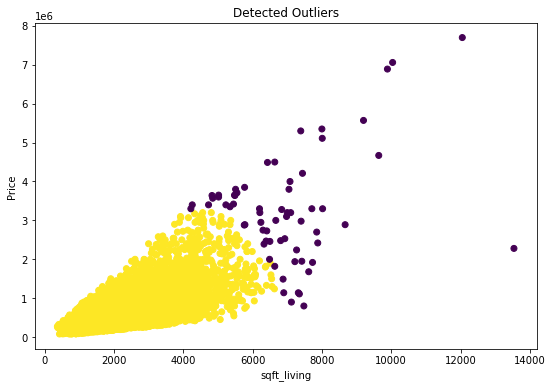

In [48]:
# scale prie and sqft_living
min_max_scaler = preprocessing.MinMaxScaler()
scaled = min_max_scaler.fit_transform(df2[['price', 'sqft_living']])

# train the DBSCAN model
model = DBSCAN(eps = 0.04, min_samples = 20).fit(scaled)

# Number of outliers detected
print('Outliers detected:', (model.labels_ < 0).sum())

# visualize the outliers
plt.figure(figsize=(9,6))
plt.scatter(df2['sqft_living'], df2['price'], c = model.labels_)

plt.title('Detected Outliers')
plt.ylabel('Price')
plt.xlabel('sqft_living')

Text(0.5, 0, 'sqft_living')

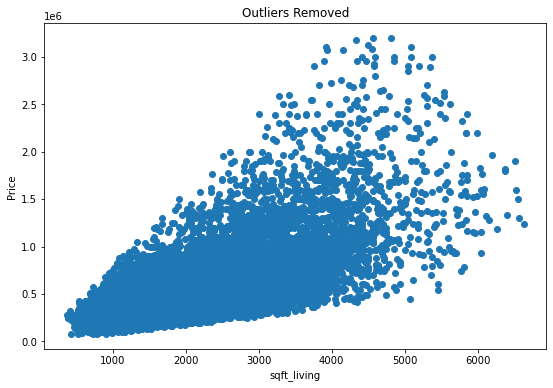

In [49]:
# remove the outliers
df3 = df2[model.labels_ > -1]

# visualize again
plt.scatter(df3['sqft_living'], df3['price'])
plt.title('Outliers Removed')
plt.ylabel('Price')
plt.xlabel('sqft_living')

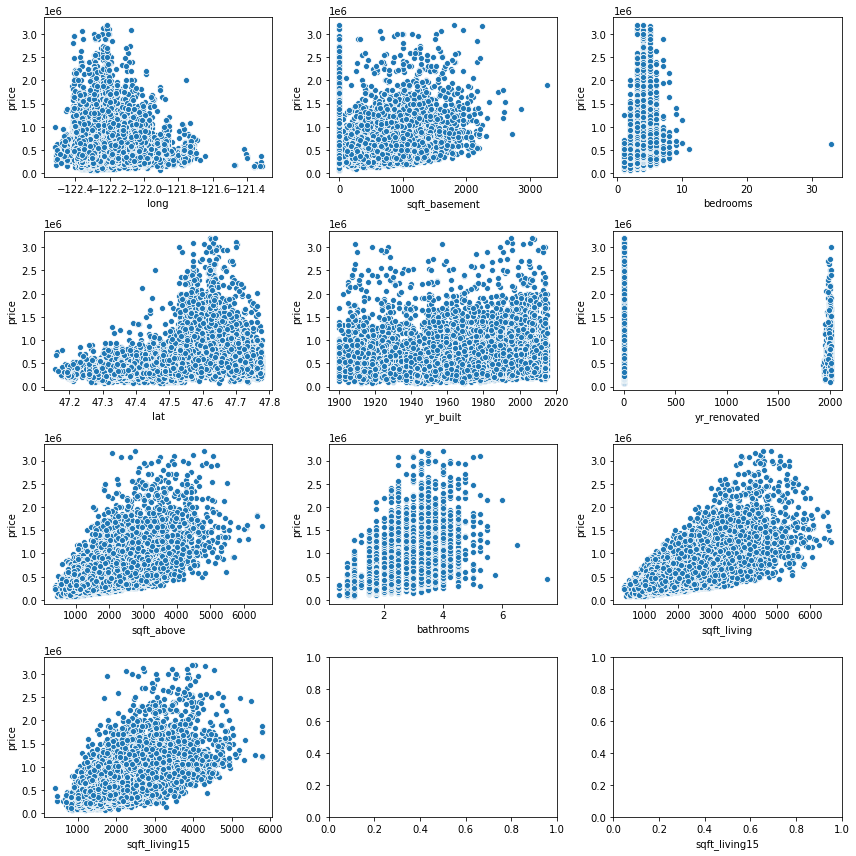

In [50]:
# see what affect that had on the other variables
scatter_cols(df3[continuous], df3['price'])

That looks much better.  We will still need to deal with `lat` and `long` but the rest look they have a fairly linear although heteroscedastic relationship to price

Now train a new model after the work so far.

In [51]:
# train a new model

X = df3.drop('price', axis=1)
y = df3['price']

quicktest(X, y, name='1 (nonlinear feature and outlier removal)', display_summary=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     3594.
Date:                Mon, 18 Jan 2021   Prob (F-statistic):               0.00
Time:                        16:31:39   Log-Likelihood:            -2.8859e+05
No. Observations:               21355   AIC:                         5.772e+05
Df Residuals:                   21340   BIC:                         5.773e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          9.734e+05   2.57e+06      0.379      0.704   -4.06e+06       6e+06
bedrooms      -2.418e+04   1709.831    -14.139      0.000   -2.75e+04   -2.08e+04
bathrooms      4.387e+04   2827.482     15.517      0.000    3.83e+04    4.94e+04
sqft_living      79.8899      2.093     38.167      0.000      75.787      83.993
waterfront     4.465e+05    1.7e+04     26.269      0.000    4.13e+05     4.8e+05
view            5.59e+04   1907.701     29.303      0.000    5.22e+04    5.96e+04
condition      2.784e+04   2099.571     13.260      0.000    2.37e+04     3.2e+04
grade              1e+05   1931.785     51.774      0.000    9.62e+04    1.04e+05
sqft_above       55.6325      1.904     29.218      0.000      51.900      59.365
sqft_basement    24.2571      2.186     11.095      0.000      19.972      28.542
yr_built      -2466.5600     62.909    -39.208      0.000   -2589.866   -2343.254
yr_renovated     23.3283      3.562      6.549      0.000      16.346      30.311
zipcode        -504.1740     29.429    -17.132      0.000    -561.857    -446.491
lat            6.009e+05   9532.986     63.034      0.000    5.82e+05     6.2e+05
long          -1.968e+05   1.15e+04    -17.120      0.000   -2.19e+05   -1.74e+05
sqft_living15    39.0924      3.105     12.590      0.000      33.006      45.178
==============================================================================
Omnibus:                    10972.929   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           162093.686
Skew:                           2.122   Prob(JB):                         0.00
Kurtosis:                      15.813   Cond. No.                     4.21e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.16e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

{'r2': 0.702,
 'train_rmse': 178838.0,
 'test_rmse': 180363.0,
 'diff_rmse': 1525.0}

In [52]:
model_report()

r2  train_rmse  test_rmse  \
baseline                                   0.700    201245.0   202880.0   
1 (nonlinear feature and outlier removal)  0.702    178838.0   180363.0   

                                           diff_rmse  
baseline                                      1635.0  
1 (nonlinear feature and outlier removal)     1525.0

# New Features

The stake holder would like to know the changing the number of Bedrooms or Bathrooms in a house.  We will try to engineer features here that may be less correlated to size and price than just the count.

## Bedroom

Bedroom is also nonlinear but we would like to try to understand the value of a bedroom for our client.  I will try to construct a feature that does have a linear relationship to price.

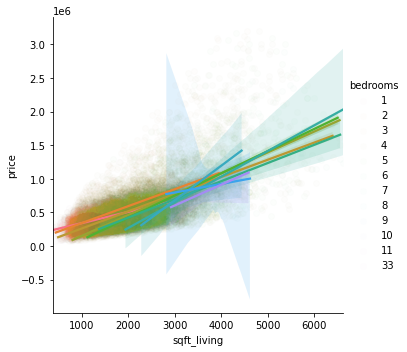

In [53]:
sns.lmplot(x='sqft_living', y='price', hue='bedrooms', 
           data=df3, scatter_kws={'alpha':0.01})

We need to narrow down the number of bedrooms and those confidence intervals indicate that the number of bedrooms associated with them are probable useless to us

In [54]:
# count number of records with each bedroom size
df3['bedrooms'].value_counts()

3     9727
4     6830
2     2735
5     1556
6      258
1      191
7       35
8       12
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

Because our stake holder is buying single family homes to fix up and sell quickly we will remove homes with a large number of bedrooms. 7 bedrooms and up have a small number of records so we will drop those.

In [55]:
# drop all records with more than 6 bedrooms
df4 = df3[df3['bedrooms'] < 7].copy()

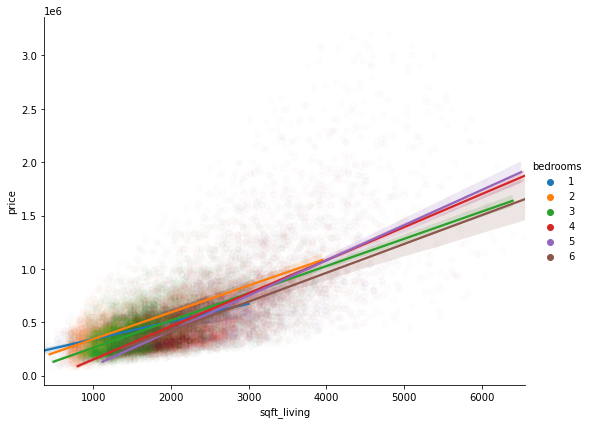

In [56]:
# retest interaction

g = sns.lmplot(x='sqft_living', y='price', hue='bedrooms', 
               data=df4, height=6, aspect=1.25,
               scatter_kws={'alpha':0.01})

for lh in g._legend.legendHandles: 
    lh.set_alpha(1)

There is some interaction between the number of bedrooms and price.  That bodes well for being able to determine the value of a bedroom.  Lets add a feature for that interaction.

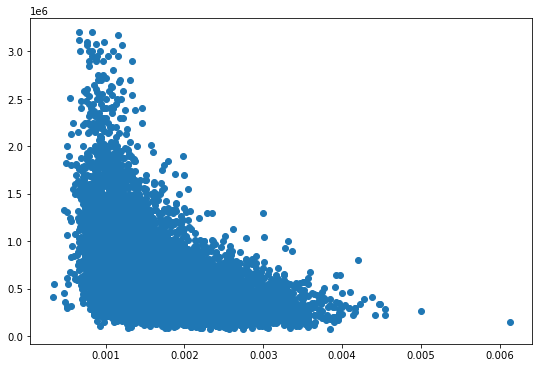

In [57]:
# create new variable
beds_per_sqft = df4['bedrooms'] / df4['sqft_living']

#see how our new variable relates to price
plt.scatter(beds_per_sqft, df4['price'])

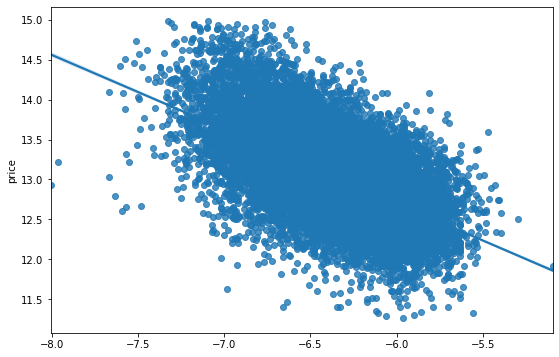

In [58]:
# visualize with price log transformed
sns.regplot(x=np.log(beds_per_sqft), y=np.log(df4['price']))

In [59]:
# save the new var to the df
df4['beds_per_sqft'] = beds_per_sqft

That does have a liner relationship.  It might tell us something.

## Bathrooms
Lets try to do something similar for bathrooms.

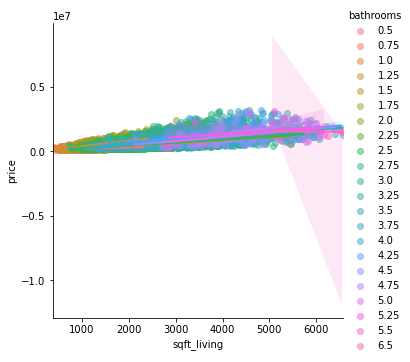

In [60]:
# test interaction
sns.lmplot(x='sqft_living', y='price', hue='bathrooms', 
           data=df4, scatter_kws={'alpha':0.5})

In [61]:
# count number of records with each bedroom size
df4['bathrooms'].value_counts()

2.50    5348
1.00    3793
1.75    3018
2.25    2028
2.00    1912
1.50    1427
2.75    1176
3.00     737
3.50     720
3.25     579
3.75     148
4.00     119
4.50      90
4.25      71
0.75      70
5.00      17
4.75      16
5.25      10
1.25       9
0.50       4
5.50       4
6.50       1
Name: bathrooms, dtype: int64

In [62]:
# see what dropping zscore above 3 would look like.
df4[np.abs(stats.zscore(df4['bathrooms'])) > 3]['bathrooms'].value_counts()

4.50    90
5.00    17
4.75    16
5.25    10
5.50     4
6.50     1
Name: bathrooms, dtype: int64

That looks too extreme to me.  I think dropping bathrooms over 5 will help us understand whether there is an interaction.

In [63]:
# drop rows with more than 4 bathrooms
df4 = df4[df4['bathrooms'] <=5]
df4['bathrooms'].value_counts()

2.50    5348
1.00    3793
1.75    3018
2.25    2028
2.00    1912
1.50    1427
2.75    1176
3.00     737
3.50     720
3.25     579
3.75     148
4.00     119
4.50      90
4.25      71
0.75      70
5.00      17
4.75      16
1.25       9
0.50       4
Name: bathrooms, dtype: int64

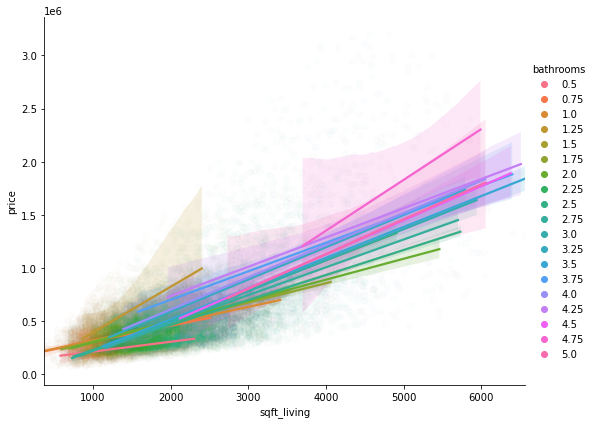

In [64]:
# retest interaction
g = sns.lmplot(x='sqft_living', y='price', hue='bathrooms', 
             height=6, aspect=1.25,
             data=df4, scatter_kws={'alpha':0.01})

#make legend handles opaque
for lh in g._legend.legendHandles: 
    lh.set_alpha(1)

That is a lot easier to see.  There are are interactions.  We cannot trust the most severe interactions because of their high confidence intervals its worth creating the new feature to reduce correlation with sqft_living.

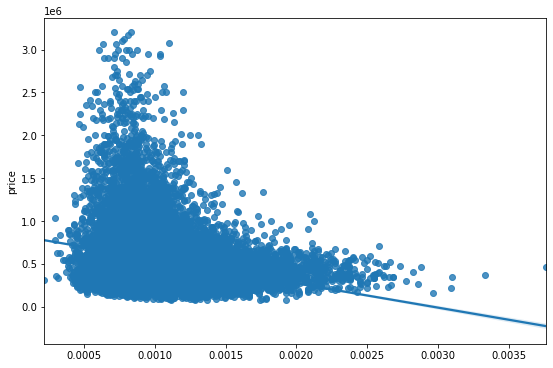

In [65]:
# create interaction variable
baths_sqft = df4['bathrooms'] / df4['sqft_living']

#plot relationship
sns.regplot(x=baths_sqft, y=df4['price'])

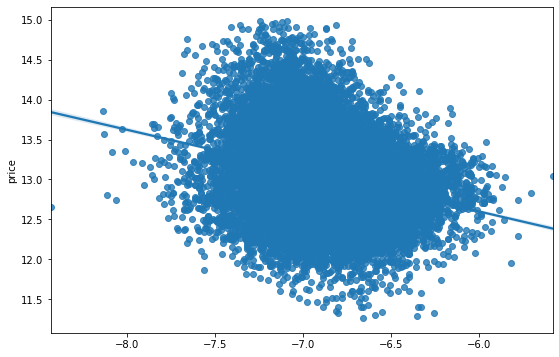

In [66]:
# replot with price log transformed
sns.regplot(x=np.log(baths_sqft), y=np.log(df4['price']))

Bathrooms * Sqft also has a linear relationship with price when price is log transformed.

In [67]:
# Add the new feature
df4['baths_per_sqft'] = baths_sqft

In [68]:
# test the model
X = df4.drop('price', axis=1)
y = df4['price']

quicktest(X, y, name='2 (bed/sqft and bath/sqft)')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     3280.
Date:                Mon, 18 Jan 2021   Prob (F-statistic):               0.00
Time:                        16:32:10   Log-Likelihood:            -2.8709e+05
No. Observations:               21282   AIC:                         5.742e+05
Df Residuals:                   21265   BIC:                         5.743e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.016e+06   2.51e+06      0.405      0.686   -3.91e+06    5.94e+06
bedrooms       -8.501e+04   3285.417    -25.875      0.000   -9.14e+04   -7.86e+04
bathrooms       6.082e+04   6701.546      9.075      0.000    4.77e+04     7.4e+04
sqft_living      135.7495      3.780     35.915      0.000     128.341     143.158
waterfront      4.417e+05   1.66e+04     26.612      0.000    4.09e+05    4.74e+05
view            5.313e+04   1870.427     28.407      0.000    4.95e+04    5.68e+04
condition       2.901e+04   2054.763     14.117      0.000     2.5e+04     3.3e+04
grade           9.834e+04   1893.184     51.942      0.000    9.46e+04    1.02e+05
sqft_above        77.9129      2.444     31.883      0.000      73.123      82.703
sqft_basement     57.8317      2.698     21.433      0.000      52.543      63.121
yr_built       -2359.0899     62.333    -37.847      0.000   -2481.267   -2236.913
yr_renovated      26.1124      3.495      7.472      0.000      19.262      32.962
zipcode         -503.3633     28.769    -17.497      0.000    -559.752    -446.974
lat             6.039e+05   9324.305     64.761      0.000    5.86e+05    6.22e+05
long           -1.912e+05   1.12e+04    -17.000      0.000   -2.13e+05   -1.69e+05
sqft_living15     42.4663      3.051     13.919      0.000      36.486      48.446
beds_per_sqft    1.27e+08   5.57e+06     22.792      0.000    1.16e+08    1.38e+08
baths_per_sqft  -9.88e+06   1.15e+07     -0.863      0.388   -3.23e+07    1.26e+07
==============================================================================
Omnibus:                    10051.355   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           135535.603
Skew:                           1.925   Prob(JB):                         0.00
Kurtosis:                      14.748   Cond. No.                     3.74e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.47e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

{'r2': 0.712,
 'train_rmse': 174544.0,
 'test_rmse': 175974.0,
 'diff_rmse': 1431.0}

In [69]:
model_report()

r2  train_rmse  test_rmse  \
baseline                                   0.700    201245.0   202880.0   
1 (nonlinear feature and outlier removal)  0.702    178838.0   180363.0   
2 (bed/sqft and bath/sqft)                 0.712    174544.0   175974.0   

                                           diff_rmse  
baseline                                      1635.0  
1 (nonlinear feature and outlier removal)     1525.0  
2 (bed/sqft and bath/sqft)                    1431.0

## Create zipcode bins

We want to find a way to use the zipcode information in an easy to explain way for the stakeholder.  We could create dummies for every zipcode but that would be cumbersome.  Here we will try to determine the optimum number of zipcode bins.

In [70]:
# create a df for our calculations
price_sqft = df4[['zipcode']].copy()

# add price per square foot
price_sqft['price_sqft'] = df4['price'] / df4['sqft_living']

# get the median price per zipcode
zip_median = price_sqft.groupby('zipcode').median()

zip_median

price_sqft
zipcode            
98001    147.275708
98002    147.534785
98003    155.171397
98004    455.136541
98005    316.340431
...             ...
98177    271.435200
98178    176.970326
98188    165.000000
98198    172.413793
98199    354.517183

[70 rows x 1 columns]

testing zipcodes with 1 bins
testing zipcodes with 2 bins
testing zipcodes with 3 bins
testing zipcodes with 4 bins
testing zipcodes with 5 bins
testing zipcodes with 6 bins
testing zipcodes with 7 bins
testing zipcodes with 8 bins
testing zipcodes with 9 bins
testing zipcodes with 10 bins
testing zipcodes with 11 bins
testing zipcodes with 12 bins
testing zipcodes with 13 bins
testing zipcodes with 14 bins


binsizes     r2  train_rmse  test_rmse
0        1.0  0.707    175804.0   177203.0
1        2.0  0.742    165066.0   166132.0
2        3.0  0.771    155469.0   156164.0
3        4.0  0.783    151388.0   152046.0
4        5.0  0.786    150365.0   151035.0
5        6.0  0.793    147854.0   148489.0
6        7.0  0.797    146589.0   147226.0
7        8.0  0.805    143406.0   144044.0
8        9.0  0.810    141712.0   142358.0
9       10.0  0.808    142369.0   142971.0
10      11.0  0.808    142328.0   142930.0
11      12.0  0.811    141425.0   142032.0
12      13.0  0.810    141710.0   142316.0
13      14.0  0.811    141409.0   142005.0

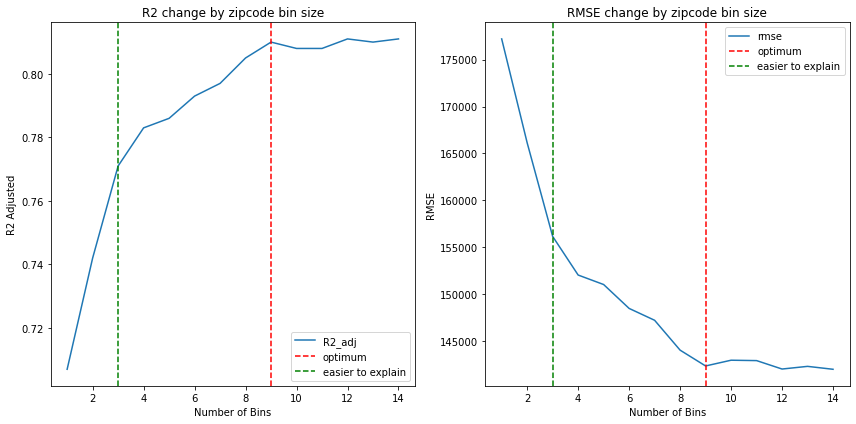

In [71]:
# An iterative test to see how many zipcode bins performs best.

# setup tracking vars
test_rmses = []
train_rmses =[]
r2s = []
binsizes = []

# function to run tests on the number of bins.
def bin_zipcodes(df, bins, drop_first=True):
    
    print(f"testing zipcodes with {bins} bins")

    # divide the zipcodes into equally sized bins
    zip_cats = pd.qcut(zip_median['price_sqft'].sort_values(), 
                       bins, labels=list(range(1, bins+1)))

    # map the categories onto zipcodes
    zipcode_cat = df['zipcode'].map(zip_cats)
    
    # create dummy vars for each bin
    dummies = pd.get_dummies(zipcode_cat, prefix='zipcat', 
                                 drop_first=drop_first)
    
    #combine with the rest of teh data 
    df = df.combine_first(dummies)
    
    # drop zipcode
    df = df.drop('zipcode', axis=1)
    
    return df
    
for bins in range(1,15):

    # get a dataframe with dummies for the number of bins
    df_temp = bin_zipcodes(df4, bins)

    # create a model amd test it
    X= df_temp.drop(columns=['price'])
    y =df_temp['price']
    summary = quicktest(X, y, display_summary=False)

    # store results
    train_rmses.append(summary['train_rmse'])
    test_rmses.append(summary['test_rmse'])
    r2s.append(summary['r2'])
    binsizes.append(bins)

# create results df
report = pd.DataFrame([binsizes, r2s, train_rmses, test_rmses]).T
report.columns = ['binsizes', 'r2', 'train_rmse', 'test_rmse']

#print results
display(pd.DataFrame(report))

# visualize results
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

# plot R2 against binsizes
plt.sca(ax1)
plt.plot(binsizes, r2s, label='R2_adj')
plt.title('R2 change by zipcode bin size')
plt.ylabel('R2 Adjusted')
plt.xlabel('Number of Bins')
plt.axvline(x=9, c='r', ls='--', label='optimum' )
plt.axvline(x=3, c='g', ls='--', label='easier to explain' )
plt.legend()

#plot rmse atains binsizes
plt.sca(ax2)
plt.plot(binsizes, test_rmses, label='rmse')
plt.title('RMSE change by zipcode bin size')
plt.ylabel('RMSE')
plt.xlabel('Number of Bins')
plt.axvline(x=9, c='r', ls='--', label='optimum' )
plt.axvline(x=3, c='g', ls='--', label='easier to explain' )
plt.legend()

plt.tight_layout()

I am going to use the "easier to explain" inflection point because we are most interested in being able to explain the relationships to the stake holder.

In [72]:
# Save the model with 3 zipcode bins

# Create new df with bins
df5 = bin_zipcodes(df4, 3, drop_first=False)

# remove zipcat_1 from the cols we are using
df5_cols = set(df5.columns)
df5_cols.difference_update({'zipcat_1', 'price'})

X = df5[sorted(df5_cols)]
y = df5['price']

quicktest(X,y,name ='3 (zipcode cats)')

testing zipcodes with 3 bins


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     4220.
Date:                Mon, 18 Jan 2021   Prob (F-statistic):               0.00
Time:                        16:32:18   Log-Likelihood:            -2.8462e+05
No. Observations:               21282   AIC:                         5.693e+05
Df Residuals:                   21264   BIC:                         5.694e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -3.844e+06   1.29e+06     -2.982      0.003   -6.37e+06   -1.32e+06
bathrooms       8.463e+04   5975.725     14.163      0.000    7.29e+04    9.63e+04
baths_per_sqft  -9.62e+07   1.03e+07     -9.377      0.000   -1.16e+08   -7.61e+07
bedrooms       -8.952e+04   2925.711    -30.597      0.000   -9.53e+04   -8.38e+04
beds_per_sqft   1.476e+08   4.97e+06     29.695      0.000    1.38e+08    1.57e+08
condition       2.901e+04   1818.286     15.954      0.000    2.54e+04    3.26e+04
grade           6.664e+04   1742.241     38.248      0.000    6.32e+04    7.01e+04
lat             2.777e+05   1.22e+04     22.695      0.000    2.54e+05    3.02e+05
long            6.449e+04   9298.267      6.935      0.000    4.63e+04    8.27e+04
sqft_above        82.6407      2.174     38.006      0.000      78.379      86.903
sqft_basement     44.1421      2.410     18.319      0.000      39.419      48.865
sqft_living      126.7334      3.367     37.639      0.000     120.134     133.333
sqft_living15     52.6565      2.702     19.489      0.000      47.361      57.952
view            4.681e+04   1659.234     28.213      0.000    4.36e+04    5.01e+04
waterfront      5.087e+05   1.48e+04     34.334      0.000     4.8e+05    5.38e+05
yr_built       -1137.1136     57.021    -19.942      0.000   -1248.879   -1025.348
yr_renovated      26.1578      3.112      8.406      0.000      20.059      32.257
zipcat_2        6.233e+04   3923.127     15.887      0.000    5.46e+04       7e+04
zipcat_3        2.573e+05   4089.938     62.916      0.000    2.49e+05    2.65e+05
==============================================================================
Omnibus:                    12106.812   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           250131.157
Skew:                           2.318   Prob(JB):                         0.00
Kurtosis:                      19.143   Cond. No.                     4.04e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.16e-20. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

{'r2': 0.771,
 'train_rmse': 155469.0,
 'test_rmse': 156164.0,
 'diff_rmse': 696.0}

In [73]:
model_report()

r2  train_rmse  test_rmse  \
baseline                                   0.700    201245.0   202880.0   
1 (nonlinear feature and outlier removal)  0.702    178838.0   180363.0   
2 (bed/sqft and bath/sqft)                 0.712    174544.0   175974.0   
3 (zipcode cats)                           0.771    155469.0   156164.0   

                                           diff_rmse  
baseline                                      1635.0  
1 (nonlinear feature and outlier removal)     1525.0  
2 (bed/sqft and bath/sqft)                    1431.0  
3 (zipcode cats)                               696.0

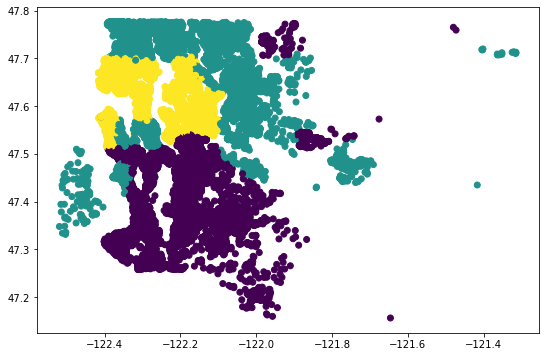

In [74]:
# visualize the zones

zones = 3
zip_cats = pd.qcut(zip_median['price_sqft'].sort_values(), zones, labels=(range(zones)))
zipcode_cat = df4['zipcode'].map(zip_cats)
plt.scatter(df5['long'], df5['lat'], c=zipcode_cat)


Thats nice but lets put it on a map.

zipcode source data: https://github.com/OpenDataDE/State-zip-code-GeoJSON

In [75]:
# load GeoJSON zipcode data for Washington state
with open('data/wa_washington_zip_codes_geo.min.json', 'r') as jsonFile:
    zip_json = json.load(jsonFile)

In [76]:
# create a df with zip as an object for filtering
zipdf = pd.DataFrame(zip_cats).reset_index()
zipdf.columns = ['zipcode', 'category']
zipdf['category'] = zipdf['category'].astype('int')
zipdf['zipcode'] = zipdf['zipcode'].astype('str')
zipdf.dtypes

zipcode     object
category     int64
dtype: object

In [77]:
# remove ZIP codes not in our dataset

# dict for storing results by zone
geozips = {1: {'type': 'FeatureCollection', 'features': []}, 
           2: {'type': 'FeatureCollection', 'features': []}, 
           3: {'type': 'FeatureCollection', 'features': []}
          }

# filter and sort json data for the zipcodes we are interested in.
for i in range(len(zip_json['features'])):

    if (zip_json['features'][i]['properties']['ZCTA5CE10'] 
        in list(zip_cats[zip_cats == 0].index.astype('str'))):
            geozips[1]['features'].append(zip_json['features'][i])
    elif (zip_json['features'][i]['properties']['ZCTA5CE10'] 
        in list(zip_cats[zip_cats == 1].index.astype('str'))):
            geozips[2]['features'].append(zip_json['features'][i])
    elif (zip_json['features'][i]['properties']['ZCTA5CE10'] 
        in list(zip_cats[zip_cats == 2].index.astype('str'))):
            geozips[3]['features'].append(zip_json['features'][i])

            
#geozips[1]
       

In [78]:
# determin map center

lat_center = (df5['lat'].min() + df5['lat'].max()) /2

long_center = (df5['long'].min() + df5['long'].max()) /2

In [79]:
# create map (tall for presentation)
m = folium.Map(location = [lat_center, long_center], zoom_start = 9,
               width=500, height=600, tiles='cartodbpositron',
              zoom_control=False)

# draw zipcodes for zone 1
m.choropleth(geo_data=geozips[1], line_color='#66aaa2', fill_color='#9ad7d2',
           line_weight=1, fill_opacity=0.3, name='Zone 1')

# draw zipcodes for zone 2
m.choropleth(geo_data=geozips[2], line_color='#f9bf3e', fill_color='#ffcb64',
           line_weight=1, fill_opacity=0.3, name='Zone 2')

# draw zipcodes for zone 3
m.choropleth(geo_data=geozips[3], line_color='#A14AB7', fill_color='#BF76D1',
           line_weight=1, fill_opacity=0.3, name='Zone 3')

m

# Correlations

Look for correlations in the data that could effect our ability to interpret the coefs.

In [80]:
# generate a nice correlation heatmap
def corr_heatmap(df,figsize=(6, 4),hide_prefix=False):
    '''Output a correlation heatmap from a Pandas DataFrame'''
    
    # hide selected prefix
    if hide_prefix:
        df = df[df.columns[~df.columns.str.startswith(hide_prefix)]]
    
    #cols = set(df.columns)
    
    # Compute the correlation matrix
    corr = df[sorted(df.columns)].corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap,
                linewidths=0.3, cbar_kws={"shrink": .7},
                vmin=-1, vmax=1, annot=True);

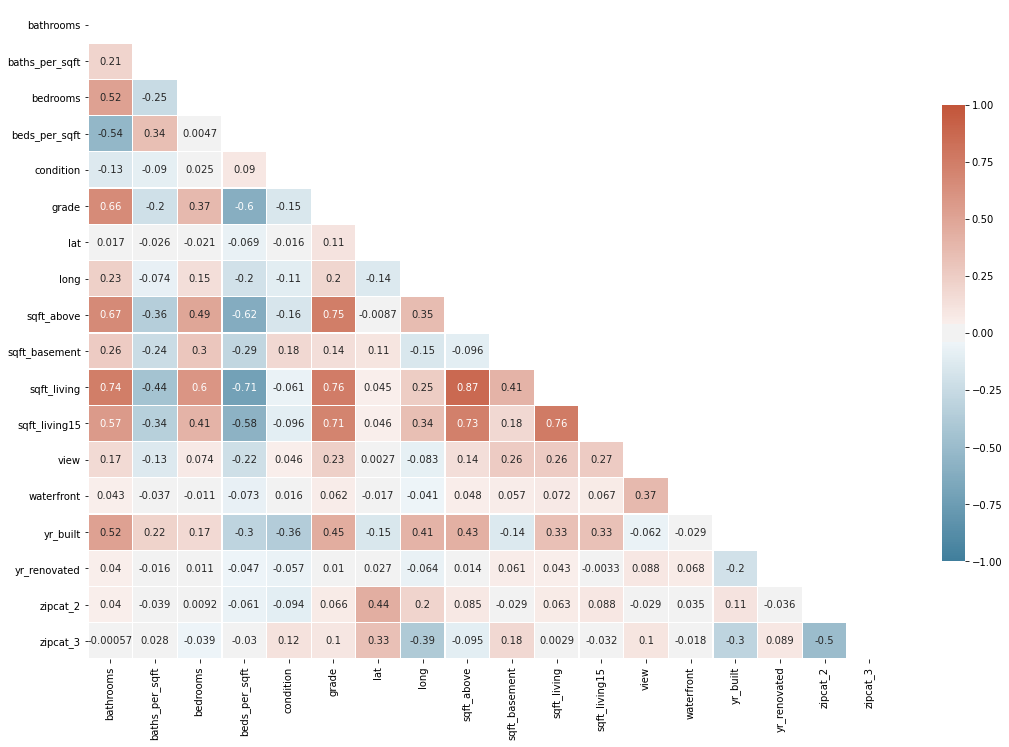

In [81]:
corr_heatmap(df5[df5_cols],figsize=(18,12))

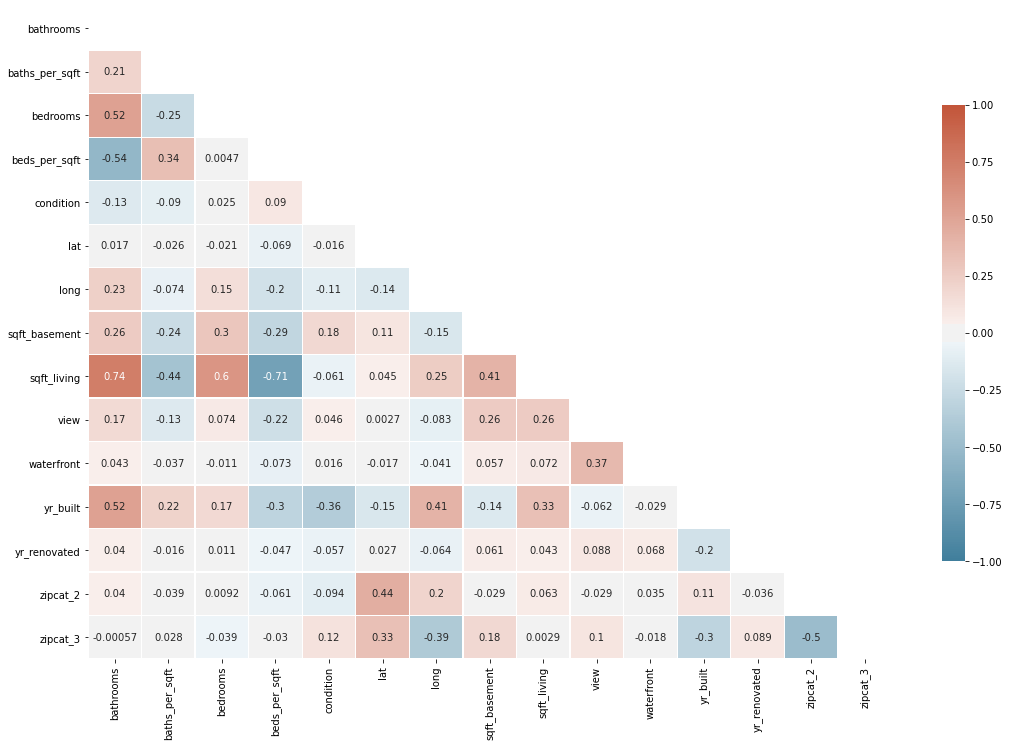

In [82]:
# Drop some of the big offenders
df5_cols.difference_update({'grade','sqft_above', 'sqft_living15'})
corr_heatmap(df5[df5_cols],figsize=(18,12))

Sqft living still has pretty high correlations with several variables.  Lets see if that has an intersection with zipcode_cat to lower its correlation with other vars.

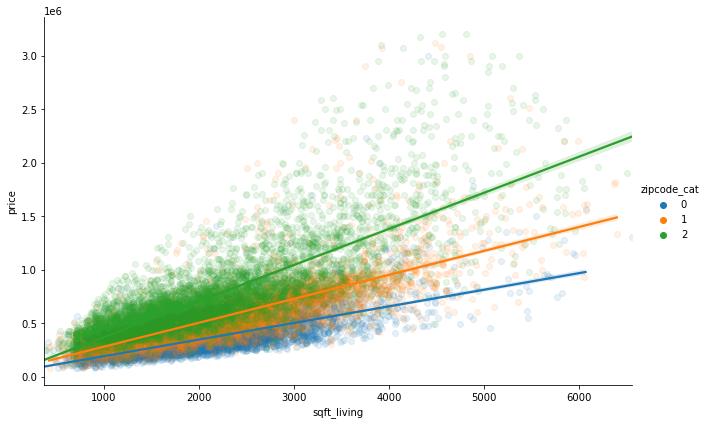

In [83]:
# create a temporary test df
df_lm = df5[['price', 'sqft_living']].copy()

# add zipcode_cat
df_lm['zipcode_cat'] = zipcode_cat

# visualize interations
g = sns.lmplot(x='sqft_living', y='price', hue='zipcode_cat',
           height=6, aspect=1.5, 
           data=df_lm, scatter_kws={'alpha':0.1})

# make legend handles opaque
for lh in g._legend.legendHandles: 
    lh.set_alpha(1)

There is an interaction.  We need all zipcode_cat dummies in our dataframe to multiply by.

In [84]:
# create new df reference for organization
df6 = df5
df6_cols = df5_cols
df6_cols

{'bathrooms',
 'baths_per_sqft',
 'bedrooms',
 'beds_per_sqft',
 'condition',
 'lat',
 'long',
 'sqft_basement',
 'sqft_living',
 'view',
 'waterfront',
 'yr_built',
 'yr_renovated',
 'zipcat_2',
 'zipcat_3'}

In [85]:
# multiply sqft_living by each zipcat and drop sqft_living

df6['zipcat_1_x_sqft_living'] = df6['sqft_living'] * df6['zipcat_1']
df6['zipcat_2_x_sqft_living'] = df6['sqft_living'] * df6['zipcat_2']
df6['zipcat_3_x_sqft_living'] = df6['sqft_living'] * df6['zipcat_3']

# remove old colums from
df6_cols = df5_cols.difference({'zipcat_1', 'zipcat_2', 'zipcat_3', 'sqft_living'})

# add new columns
df6_cols.update({'zipcat_1_x_sqft_living',
                 'zipcat_2_x_sqft_living',
                 'zipcat_3_x_sqft_living'})
df6_cols

{'bathrooms',
 'baths_per_sqft',
 'bedrooms',
 'beds_per_sqft',
 'condition',
 'lat',
 'long',
 'sqft_basement',
 'view',
 'waterfront',
 'yr_built',
 'yr_renovated',
 'zipcat_1_x_sqft_living',
 'zipcat_2_x_sqft_living',
 'zipcat_3_x_sqft_living'}

In [86]:
X = df6[sorted(df6_cols)]
y = df6['price']

quicktest(X, y, name='4 (zip sqft interaction)')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     5010.
Date:                Mon, 18 Jan 2021   Prob (F-statistic):               0.00
Time:                        16:32:32   Log-Likelihood:            -2.8424e+05
No. Observations:               21282   AIC:                         5.685e+05
Df Residuals:                   21266   BIC:                         5.686e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -3.613e+06    1.2e+06     -3.020      0.003   -5.96e+06   -1.27e+06
bathrooms               7.864e+04   5852.861     13.436      0.000    6.72e+04    9.01e+04
baths_per_sqft         -8.221e+07      1e+07     -8.194      0.000   -1.02e+08   -6.25e+07
bedrooms               -8.452e+04   2870.986    -29.439      0.000   -9.01e+04   -7.89e+04
beds_per_sqft           1.128e+08   4.88e+06     23.100      0.000    1.03e+08    1.22e+08
condition               2.141e+04   1788.036     11.972      0.000    1.79e+04    2.49e+04
lat                     2.873e+05   1.08e+04     26.528      0.000    2.66e+05    3.08e+05
long                    7.692e+04   8833.240      8.708      0.000    5.96e+04    9.42e+04
sqft_basement            -98.7638      2.954    -33.432      0.000    -104.554     -92.973
view                    5.477e+04   1602.226     34.186      0.000    5.16e+04    5.79e+04
waterfront              5.245e+05   1.46e+04     36.019      0.000    4.96e+05    5.53e+05
yr_built                -388.0402     53.364     -7.272      0.000    -492.637    -283.443
yr_renovated              19.5041      3.052      6.390      0.000      13.521      25.487
zipcat_1_x_sqft_living   220.7406      4.924     44.832      0.000     211.090     230.391
zipcat_2_x_sqft_living   265.1870      4.733     56.032      0.000     255.910     274.464
zipcat_3_x_sqft_living   374.4600      4.702     79.641      0.000     365.244     383.676
==============================================================================
Omnibus:                     9906.714   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           191474.559
Skew:                           1.772   Prob(JB):                         0.00
Kurtosis:                      17.261   Cond. No.                     2.32e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.32e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

{'r2': 0.779,
 'train_rmse': 152742.0,
 'test_rmse': 153048.0,
 'diff_rmse': 306.0}

The model improved again but the pvalue of `zipcat_2_x_sqft_living` is very high.  We will keep an eye on that as we remove more correlations.

In [87]:
model_report()

r2  train_rmse  test_rmse  \
baseline                                   0.700    201245.0   202880.0   
1 (nonlinear feature and outlier removal)  0.702    178838.0   180363.0   
2 (bed/sqft and bath/sqft)                 0.712    174544.0   175974.0   
3 (zipcode cats)                           0.771    155469.0   156164.0   
4 (zip sqft interaction)                   0.779    152742.0   153048.0   

                                           diff_rmse  
baseline                                      1635.0  
1 (nonlinear feature and outlier removal)     1525.0  
2 (bed/sqft and bath/sqft)                    1431.0  
3 (zipcode cats)                               696.0  
4 (zip sqft interaction)                       306.0

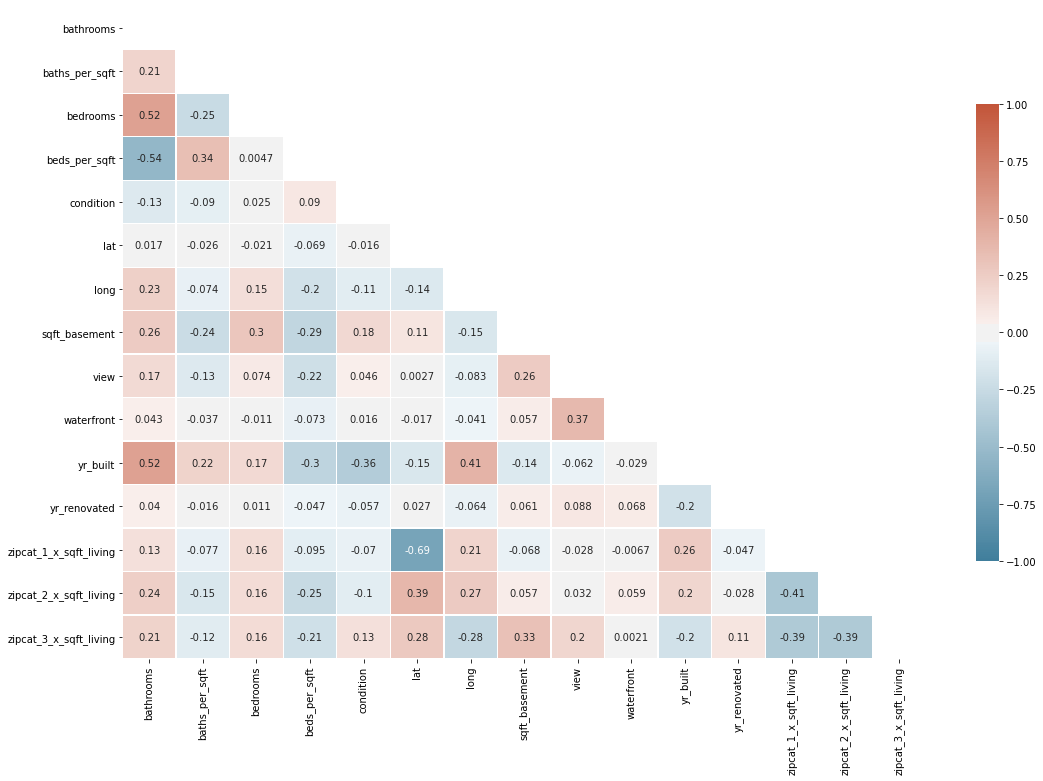

In [88]:
corr_heatmap(df6[df6_cols], figsize=(18,12))

Thats not too bad so lets move on to multicollinearity which will probably take care of some of the higher values here.

# Multicolinearity

In [89]:
### Function to check vif for all cols
def multicolinearity_check(df, add_constant=False):
    '''Takes a DataFrame and prints variance_inflation_vactor for all cols'''
    vifs = []
    
    # does it need a constant?  Hard to tell?
    # https://github.com/statsmodels/statsmodels/issues/2376#issuecomment-97167385
    # https://stackoverflow.com/questions/59694427/what-does-the-high-vif-for-the-constant-term-intercept-indicate
    if add_constant:
        df = sm.add_constant(df)
    
    # get vif fore each value passed
    for i, col in enumerate(df.columns):
        vif = variance_inflation_factor(df.values, i)
        vifs.append(vif)
    
    # create dataframe for display
    vifs = pd.DataFrame(vifs, index=df.columns,columns=['vif'])
    vifs = vifs.sort_values(by='vif', ascending=False)
    
    # show results
    display(HTML('<H3>MULTICOLINIERITY CHECK (vif)'))
    display(vifs);

In [90]:
multicolinearity_check(df6[df6_cols])

vif
long                    211232.209530
lat                     206835.851458
yr_built                  9049.440146
bathrooms                  155.398097
baths_per_sqft             115.636936
bedrooms                    90.157544
beds_per_sqft               76.763015
zipcat_2_x_sqft_living      37.643906
condition                   34.444713
zipcat_3_x_sqft_living      33.294712
zipcat_1_x_sqft_living      32.701646
sqft_basement                2.105640
view                         1.448392
waterfront                   1.179574
yr_renovated                 1.146891

It looks like because sqft_basement and sqft_above sum to sqft_living those columns have an inf vif.  Removing one should solve the problem.

In [91]:
# create a df alias for easy numbering
df7 = df6

# create a new columns for df7
df7_cols = df6_cols.difference({'sqft_basement'})

# recheck multicoliniarity
multicolinearity_check(df7[df7_cols])

vif
long                    209328.152846
lat                     206222.652096
yr_built                  8650.514895
bathrooms                  154.612654
baths_per_sqft             114.731301
bedrooms                    87.873264
beds_per_sqft               75.131688
zipcat_2_x_sqft_living      37.244716
condition                   34.095553
zipcat_3_x_sqft_living      32.781575
zipcat_1_x_sqft_living      32.487513
view                         1.424975
waterfront                   1.178819
yr_renovated                 1.145871

In [92]:

# remove other columna with high multi coliniarity
df7_cols.difference_update({'long', 'lat', 'yr_built', 'grade', 'sqft_living15',
                           'bathrooms', 'bedrooms', 
                           'condition', 'sqft_above'})

multicolinearity_check(df7[df7_cols])

vif
baths_per_sqft          11.178991
beds_per_sqft            9.269905
zipcat_3_x_sqft_living   1.955799
zipcat_1_x_sqft_living   1.914652
zipcat_2_x_sqft_living   1.875042
view                     1.384533
waterfront               1.175654
yr_renovated             1.054273

Here I suspect we could drop either `beds_per_sqft` or `baths_per_sqft`.

In [93]:
# test with baths_per_sqft
df7_cols_baths = df7_cols.difference({'beds_per_sqft'})
multicolinearity_check(df7[df7_cols_baths])

vif
baths_per_sqft          3.403213
zipcat_3_x_sqft_living  1.953166
zipcat_1_x_sqft_living  1.902533
zipcat_2_x_sqft_living  1.873166
view                    1.381167
waterfront              1.175589
yr_renovated            1.054267

In [94]:
X = df7[sorted(df7_cols_baths)]
y = df7['price']

quicktest(X,y,name = '5.1 (baths_per_sqft)')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     8943.
Date:                Mon, 18 Jan 2021   Prob (F-statistic):               0.00
Time:                        16:32:35   Log-Likelihood:            -2.8572e+05
No. Observations:               21282   AIC:                         5.715e+05
Df Residuals:                   21274   BIC:                         5.715e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   1.449e+04   6322.398      2.291      0.022    2093.278    2.69e+04
baths_per_sqft          2.837e+07   3.97e+06      7.150      0.000    2.06e+07    3.62e+07
view                    4.877e+04   1678.294     29.060      0.000    4.55e+04    5.21e+04
waterfront              5.409e+05   1.56e+04     34.709      0.000     5.1e+05    5.71e+05
yr_renovated              19.5802      3.131      6.253      0.000      13.443      25.718
zipcat_1_x_sqft_living   145.5139      1.726     84.294      0.000     142.130     148.898
zipcat_2_x_sqft_living   220.2315      1.589    138.580      0.000     217.117     223.346
zipcat_3_x_sqft_living   320.4502      1.650    194.267      0.000     317.217     323.683
==============================================================================
Omnibus:                     9726.449   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           162983.664
Skew:                           1.773   Prob(JB):                         0.00
Kurtosis:                      16.085   Cond. No.                     4.81e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.81e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

{'r2': 0.746,
 'train_rmse': 163786.0,
 'test_rmse': 164198.0,
 'diff_rmse': 412.0}

In [95]:
# try with baths_per_sqft
df7_cols_beds = df7_cols.difference({'baths_per_sqft'})
multicolinearity_check(df7[df7_cols_beds])

vif
beds_per_sqft           2.822031
zipcat_3_x_sqft_living  1.752351
zipcat_1_x_sqft_living  1.733774
zipcat_2_x_sqft_living  1.657522
view                    1.383924
waterfront              1.175505
yr_renovated            1.053801

In [96]:
X = df7[sorted(df7_cols_beds)]
y = df7['price']

quicktest(X,y,name = '5.2 (beds_per_sqft)')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     8917.
Date:                Mon, 18 Jan 2021   Prob (F-statistic):               0.00
Time:                        16:32:36   Log-Likelihood:            -2.8575e+05
No. Observations:               21282   AIC:                         5.715e+05
Df Residuals:                   21274   BIC:                         5.716e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   7.052e+04   8339.430      8.456      0.000    5.42e+04    8.69e+04
beds_per_sqft          -5.838e+06   2.85e+06     -2.049      0.040   -1.14e+07   -2.55e+05
view                    4.838e+04   1680.864     28.784      0.000    4.51e+04    5.17e+04
waterfront              5.407e+05   1.56e+04     34.659      0.000     5.1e+05    5.71e+05
yr_renovated              19.5121      3.135      6.223      0.000      13.367      25.658
zipcat_1_x_sqft_living   138.2871      2.053     67.363      0.000     134.263     142.311
zipcat_2_x_sqft_living   212.9648      1.960    108.654      0.000     209.123     216.807
zipcat_3_x_sqft_living   313.3834      2.000    156.687      0.000     309.463     317.304
==============================================================================
Omnibus:                     9731.614   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           163843.131
Skew:                           1.773   Prob(JB):                         0.00
Kurtosis:                      16.122   Cond. No.                     3.45e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.45e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

{'r2': 0.746,
 'train_rmse': 163967.0,
 'test_rmse': 164370.0,
 'diff_rmse': 403.0}

Both of the above models look great for answering how much value a bedroom or bathroom adds to a house without changing the sqft of the house.  The single metric beds_per_sqft can be used to determine the value for us.

All of the p values, confidence intervals, and $R^2$ look good.

In [97]:
model_report()

r2  train_rmse  test_rmse  \
baseline                                   0.700    201245.0   202880.0   
1 (nonlinear feature and outlier removal)  0.702    178838.0   180363.0   
2 (bed/sqft and bath/sqft)                 0.712    174544.0   175974.0   
3 (zipcode cats)                           0.771    155469.0   156164.0   
4 (zip sqft interaction)                   0.779    152742.0   153048.0   
5.1 (baths_per_sqft)                       0.746    163786.0   164198.0   
5.2 (beds_per_sqft)                        0.746    163967.0   164370.0   

                                           diff_rmse  
baseline                                      1635.0  
1 (nonlinear feature and outlier removal)     1525.0  
2 (bed/sqft and bath/sqft)                    1431.0  
3 (zipcode cats)                               696.0  
4 (zip sqft interaction)                       306.0  
5.1 (baths_per_sqft)                           412.0  
5.2 (beds_per_sqft)                            403.0

# Model Assumptions

In [98]:
# a function to visualize model assumptions
def visualize_assumptions(model, df):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))
    
    #qq plot
    sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True, ax=ax1);
    plt.gca()
    plt.title('QQ Plot')
    
    # distribution plot of residuals
    sns.distplot(model.resid, ax=ax2)
    plt.gca()
    plt.title('Distribution of Residuals')
    plt.xlabel('Residuals')
    
    # scatter plot of residuals for visualizing homoscedasticity
    sns.scatterplot(x=model.predict(sm.add_constant(df)),
                    y=model.resid,
                    ax=ax3)
                    
    plt.gca()
    plt.title("Residual Plot")
    plt.ylabel('Residuals')
    plt.xlabel('Predicted Price')
    plt.axhline(0)
    
    #force show before JB Test
    plt.show()
    
    # JB test
    name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
    test = sms.jarque_bera(model.resid)
    print(pd.Series(test, index=name))

## Check current model
Working through verifying the assumptions we will use a model with both `bed_x_sqft` and `bath_x_sqft`.  At the end we can check the two models independently.

In [99]:
# visualize model with both baths and beds
X = df7[sorted(df7_cols)]
y = df7['price']

model = sm.OLS(y, sm.add_constant(X)).fit()
model.rsquared

0.7464253442987385

In [100]:
cross_validate_rmse(X,y)

(163765.51105491546, 164181.61340973605, 416.1023548205849)

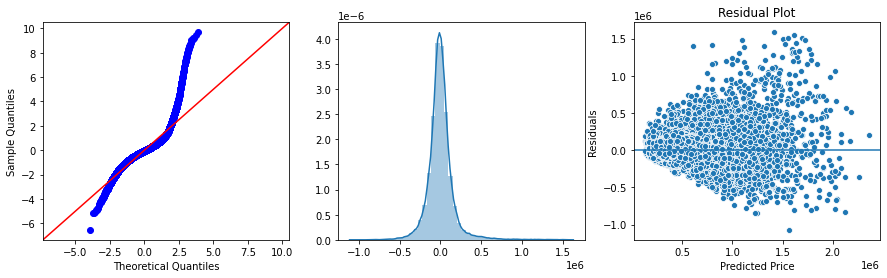

Jarque-Bera    163792.934121
Prob                0.000000
Skew                1.779776
Kurtosis           16.116444
dtype: float64


In [101]:
visualize_assumptions(model, X)

## log transform price

From here on we will start using the formula api for creating the model because it will do the log transformations for us.

In [102]:
#change to using formulas
f = 'np.log(price) ~ ' + ' + '.join(df7_cols)

model = ols(f, df7).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(price)   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     7584.
Date:                Mon, 18 Jan 2021   Prob (F-statistic):               0.00
Time:                        16:32:38   Log-Likelihood:                -1624.7
No. Observations:               21282   AIC:                             3267.
Df Residuals:                   21273   BIC:                             3339.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 12.5039      0.016    791.956      0.000      12.473      12.535
beds_per_sqft           -104.8151      4.538    -23.095      0.000    -113.711     -95.920
baths_per_sqft            50.5930      6.329      7.994      0.000      38.187      62.999
zipcat_3_x_sqft_living     0.0005   3.32e-06    137.280      0.000       0.000       0.000
zipcat_2_x_sqft_living     0.0003   3.26e-06    100.958      0.000       0.000       0.000
waterfront                 0.4460      0.025     17.954      0.000       0.397       0.495
yr_renovated            2.561e-05   4.99e-06      5.130      0.000    1.58e-05    3.54e-05
zipcat_1_x_sqft_living     0.0002   3.41e-06     50.215      0.000       0.000       0.000
view                       0.0519      0.003     19.401      0.000       0.047       0.057
==============================================================================
Omnibus:                      614.219   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1386.933
Skew:                          -0.148   Prob(JB):                    6.78e-302
Kurtosis:                       4.215   Cond. No.                     4.81e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.81e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

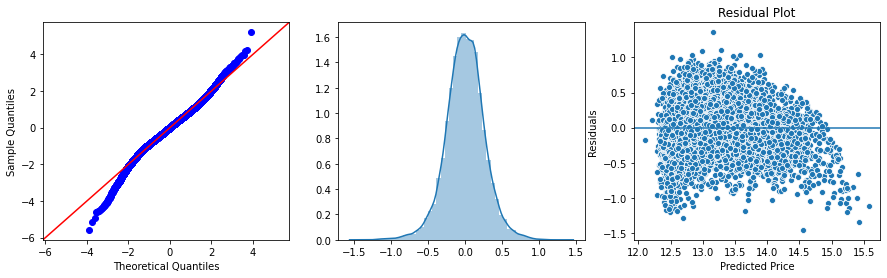

Jarque-Bera     1.386933e+03
Prob           6.781919e-302
Skew           -1.480728e-01
Kurtosis        4.215056e+00
dtype: float64


In [103]:
y, X = patsy.dmatrices(f, df7, return_type='dataframe')
model = sm.OLS(y, X).fit()
visualize_assumptions(model, X)

In [104]:
cross_validate_rmse(X,y,delog_y=True)

(195553.18056960567, 195946.90403872504, 393.7234691193735)

Thats no good.  Log transforming only price lowered our $R^2$ and didn't solve the problem of heterscedasticity of the residuals.  The residuals do look much more normal though.

## log transform price and sqft_living and new metrics based on sqft

In [105]:
f = '''
np.log(price) ~
np.log(baths_per_sqft)
+ np.log(beds_per_sqft)
+ view 
+ waterfront 
+ yr_renovated 
+ np.log(sqft_living):zipcat_1 
+ np.log(sqft_living):zipcat_2
+ np.log(sqft_living):zipcat_3
'''
model_1 = ols(f, df7).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(price)   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     9303.
Date:                Mon, 18 Jan 2021   Prob (F-statistic):               0.00
Time:                        16:32:40   Log-Likelihood:                 25.950
No. Observations:               21282   AIC:                            -33.90
Df Residuals:                   21273   BIC:                             37.79
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        7.2252      0.046    157.520      0.000       7.135       7.315
np.log(baths_per_sqft)           0.0558      0.007      8.533      0.000       0.043       0.069
np.log(beds_per_sqft)           -0.1425      0.008    -17.989      0.000      -0.158      -0.127
view                             0.0673      0.002     27.314      0.000       0.062       0.072
waterfront                       0.4466      0.023     19.434      0.000       0.402       0.492
yr_renovated                  2.345e-05   4.62e-06      5.079      0.000    1.44e-05    3.25e-05
np.log(sqft_living):zipcat_1     0.6527      0.006    105.520      0.000       0.641       0.665
np.log(sqft_living):zipcat_2     0.7024      0.006    113.402      0.000       0.690       0.715
np.log(sqft_living):zipcat_3     0.7438      0.006    119.599      0.000       0.732       0.756
==============================================================================
Omnibus:                      424.408   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              906.686
Skew:                           0.047   Prob(JB):                    1.30e-197
Kurtosis:                       4.007   Cond. No.                     1.03e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

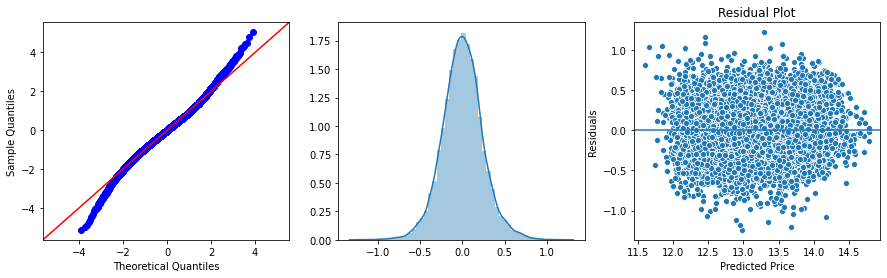

Jarque-Bera     9.066862e+02
Prob           1.304945e-197
Skew            4.734981e-02
Kurtosis        4.006734e+00
dtype: float64


In [106]:
y, X = patsy.dmatrices(f, df7, return_type='dataframe')
model = sm.OLS(y, X).fit()
visualize_assumptions(model, X)

In [107]:
cross_validate_rmse(X, y, delog_y=True), cross_validate_rmse(X, y, delog_y=False)

((165559.95540816773, 165927.58678503358, 367.6313768658438),
 (0.24160548522783762, 0.24226720679302116, 0.0006617215651835429))

That is much better.  This version has an $R^2$ higher than our model with untransformed independent variables and and results in residuals that look normal and heteroscedastic enough.

# Interpretation

In the end we have 3 models.  One to predict home prices and determine the value of adding squarefootage to a house.  Then two other models for predicting the value of adding a bedroom or bathroom to the existing square footage.  These final two models were necessary because of high vifs between them in the first model.  These vifs, however do not effect the sqfootage estimates for which the vif remains low.

## Final Model 1 - Price prediction and value estimation

In [108]:
#this is the same as the last model, save it
quicktest(X, y, name='Final Model 1: Price prediction and value estimation', 
          delog_rmse=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(price)   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     9303.
Date:                Mon, 18 Jan 2021   Prob (F-statistic):               0.00
Time:                        16:32:42   Log-Likelihood:                 25.950
No. Observations:               21282   AIC:                            -33.90
Df Residuals:                   21273   BIC:                             37.79
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        7.2252      0.046    157.520      0.000       7.135       7.315
np.log(baths_per_sqft)           0.0558      0.007      8.533      0.000       0.043       0.069
np.log(beds_per_sqft)           -0.1425      0.008    -17.989      0.000      -0.158      -0.127
view                             0.0673      0.002     27.314      0.000       0.062       0.072
waterfront                       0.4466      0.023     19.434      0.000       0.402       0.492
yr_renovated                  2.345e-05   4.62e-06      5.079      0.000    1.44e-05    3.25e-05
np.log(sqft_living):zipcat_1     0.6527      0.006    105.520      0.000       0.641       0.665
np.log(sqft_living):zipcat_2     0.7024      0.006    113.402      0.000       0.690       0.715
np.log(sqft_living):zipcat_3     0.7438      0.006    119.599      0.000       0.732       0.756
==============================================================================
Omnibus:                      424.408   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              906.686
Skew:                           0.047   Prob(JB):                    1.30e-197
Kurtosis:                       4.007   Cond. No.                     1.03e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

{'r2': 0.778,
 'train_rmse': 165560.0,
 'test_rmse': 165928.0,
 'diff_rmse': 368.0}

In [109]:
cross_validate_rmse(X, y)

(0.24160548522783762, 0.24226720679302116, 0.0006617215651835429)

Since this model can be used for prediction, create a function to easily take the entered values and transform them to the values the model needs.  The formula does much of this, but not all.  In the future it would be good to write transformation functions for patsy to use when transforming the input variables so they could easily be applied here too.

In [110]:
# predict a price from arbitrary input.
def predict(baths, beds, view, waterfront, yr_renovated, sqft_living, zone):
    
    # create metrics 
    baths_per_sqft = baths/sqft_living
    beds_per_sqft = beds/sqft_living
    zipcat_1 = zipcat_2 = zipcat_3 = 0
    
    # set zone
    if zone == 1:
        zipcat_1 = 1
    elif zone == 2:
        zipcat_2 = 1
    elif zone == 3:
        zipcat_3 = 1
    
    # create dataframe
    values = {'baths_per_sqft':[baths_per_sqft],
              'beds_per_sqft':[beds_per_sqft],
              'view':[view],
              'waterfront':[waterfront],
              'yr_renovated':[yr_renovated],
              'sqft_living':[sqft_living],
              'zipcat_1':[zipcat_1],
              'zipcat_2':[zipcat_2],
              'zipcat_3':[zipcat_3]
             }
    to_pred = pd.DataFrame.from_dict(values)
    
    # predict
    pred = model_1.predict(to_pred)
    
    # return inverse log transformed prediction
    return round(np.exp(pred[0]))

In [111]:
# predict the value of a madeup house.
predict(baths=2, beds=2, view=1, waterfront=0, 
        yr_renovated=1995, sqft_living=1450, zone=1)

315307.0

I will need to show someone who doesn't understand residuals and models a visual to help them understand what the model can and cannot do.

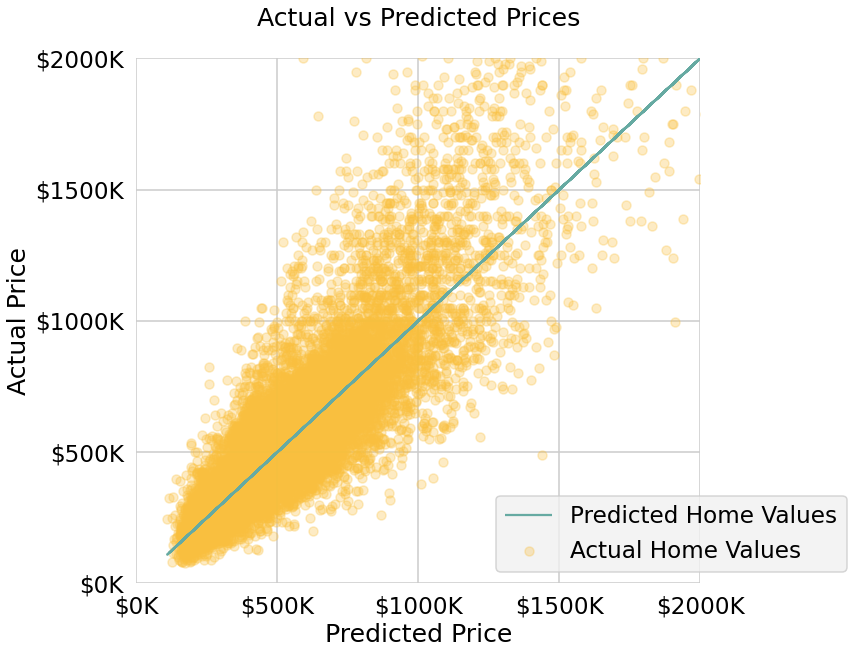

In [112]:
# get the predicted values
prediction = np.exp(model_1.predict(df7))

# create a formater for the dolar values in thousands
def k_thousands_formater(x, pos):
    'The two args are the value and tick position'
    return '$%1.0fK' % (x * 1e-3)


#plot the figure
with plt.style.context('fivethirtyeight'), sns.plotting_context("talk", font_scale=1.4):

    fig = plt.figure(figsize=(9,9))
    plt.scatter(prediction,df7['price'], alpha=0.3, color='#f9bf3e', label='Actual Home Values')
    plt.plot(prediction,prediction, color='#66aaa2', label='Predicted Home Values')
    
    
    
    plt.xlabel('Predicted Price')
    plt.ylabel('Actual Price')
    plt.title('Actual vs Predicted Prices')
    
    # get axis
    ax = plt.gca()
    
    # set x and y limits
    ax.set_xlim([0, 2000000])
    ax.set_ylim([0, 2000000])
   
    # format labels
    formatter = FuncFormatter(k_thousands_formater)    
    ax.yaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_formatter(formatter)
    
    # format design
    ax.title.set_position([.5, 1.05])
    plt.locator_params(nbins=4)
    fig.set_facecolor('None')
    ax.tick_params(axis='both', bottom=False, left=False)
    ax.set_facecolor('None')
    for s in ax.spines.values():
        s.set_visible(False)
    
    # and and place the legend
    plt.legend(loc=0, bbox_to_anchor=(0,0,1.28,1))

 This model can also be used to determine the value of adding square footage to the home.  The coefficient for `sqft_living` has an interaction with zipcode zone.  Because both the dependent and independent variables are log transformed the price after adding square footage to the home can be determined by the following formula where `coef` is the `coef` associated with the zipcode zone for the property:

$$ \textbf{Starting Value} \cdot \left( \frac{\textbf{sqft after}}{\textbf{sqft before}} \right)^{coef}
= \textbf {New Price}$$



## Final Model 2 - Bedrooms

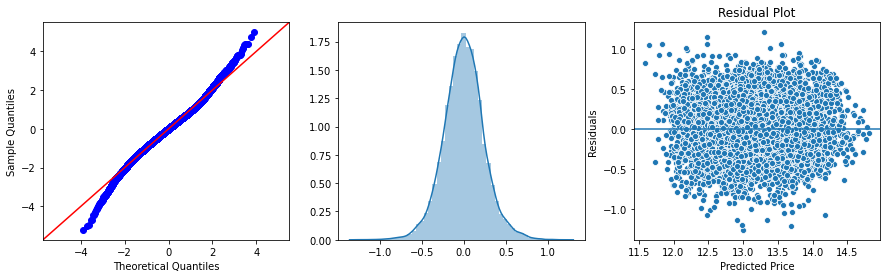

Jarque-Bera     9.012095e+02
Prob           2.017671e-196
Skew            2.007753e-02
Kurtosis        4.007320e+00
dtype: float64


None

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(price)   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                 1.059e+04
Date:                Mon, 18 Jan 2021   Prob (F-statistic):               0.00
Time:                        16:32:45   Log-Likelihood:                -10.413
No. Observations:               21282   AIC:                             36.83
Df Residuals:                   21274   BIC:                             100.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        6.9756      0.035    197.086      0.000       6.906       7.045
np.log(beds_per_sqft)           -0.1374      0.008    -17.369      0.000      -0.153      -0.122
view                             0.0665      0.002     26.989      0.000       0.062       0.071
waterfront                       0.4469      0.023     19.412      0.000       0.402       0.492
yr_renovated                  2.378e-05   4.62e-06      5.143      0.000    1.47e-05    3.28e-05
np.log(sqft_living):zipcat_1     0.6393      0.006    106.689      0.000       0.628       0.651
np.log(sqft_living):zipcat_2     0.6889      0.006    114.836      0.000       0.677       0.701
np.log(sqft_living):zipcat_3     0.7304      0.006    121.197      0.000       0.719       0.742
==============================================================================
Omnibus:                      418.226   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              901.209
Skew:                           0.020   Prob(JB):                    2.02e-196
Kurtosis:                       4.007   Cond. No.                     7.92e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.92e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

{'r2': 0.777,
 'train_rmse': 165853.0,
 'test_rmse': 166231.0,
 'diff_rmse': 378.0}

In [113]:
f = '''
np.log(price) ~
np.log(beds_per_sqft)
+ view 
+ waterfront 
+ yr_renovated 
+ np.log(sqft_living):zipcat_1 
+ np.log(sqft_living):zipcat_2
+ np.log(sqft_living):zipcat_3
'''

#Generate the model from the function
model_baths = ols(f, df7).fit()

# get the y and X and create a df model for our visualize_assumptions function
y, X = patsy.dmatrices(f, df7, return_type='dataframe')
model = sm.OLS(y, X).fit()
display(visualize_assumptions(model, X))

# save and view results
quicktest(X, y, name='Final 2: Bedroom Effect', delog_rmse=True)

This model can be used to predict the value of changing the number of bedrooms in the existing footprint of the house.  If more square footage were added additional calculations would be necessary.

The coefficient of the variable `np.log(beds_per_sqft)` is $-0.1374$.

Because both the dependent and independent variable are log transformed we take the proportion of $Beds_2$ to $Beds_1$ to the power of the coefficient.

$$ \left( \frac{\textbf{Beds/sqft}_2}{\textbf{Beds/sqft}_1} \right) ^ {-0.1374} = 
 \left( \frac{\textbf{Beds}_2}{\textbf{Beds}_1} \right) ^ {-0.1374}
 = \textbf{Effect on housing price}$$


In [114]:
# an example calculation for a change from 2 3 bathrooms in a 2000sqft house
((3*2000)/(2*2000)) ** -0.1374

0.9458125252350632

In [115]:
# the square footage can be factored out as as in the equation above.
(3/2) ** -0.1374

0.9458125252350632

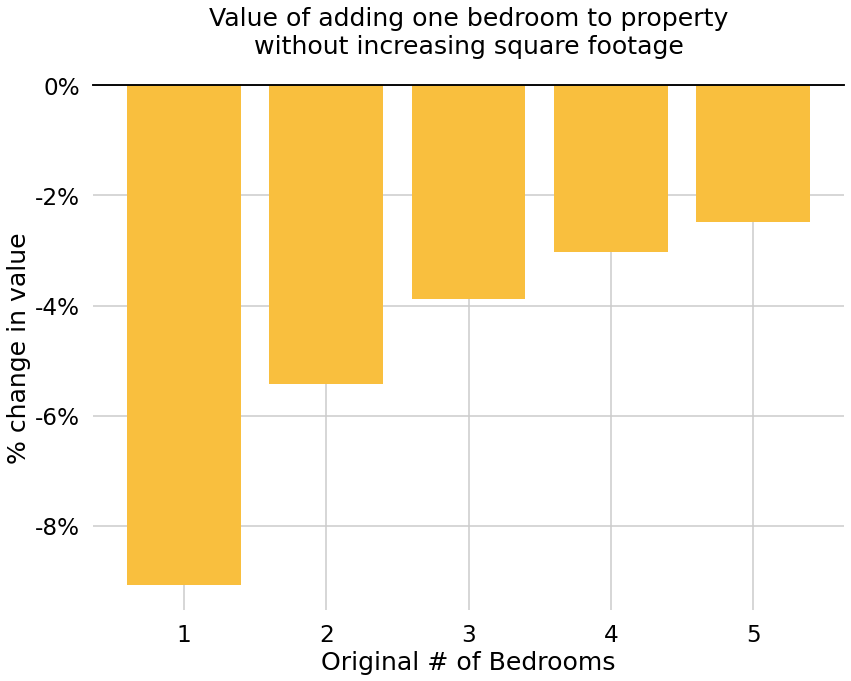

In [116]:
# create visualization

# a list of possible numbers of bedrooms
beds = np.arange(1,6,1)

# percent change to home price for adding a bedroom
percent_change = ((beds+1)/beds)**-0.1374 - 1

with plt.style.context('fivethirtyeight'), sns.plotting_context("talk", font_scale=1.4):

    # create figure
    fig = plt.figure(figsize = (12,9))

    # plot
    plt.bar(beds, percent_change, color='#f9bf3e')
    
    # get current axis
    ax = plt.gca()
    
    # percent format y ticks
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(1, decimals=0))
    
    # Labels
    plt.title('Value of adding one bedroom to property\nwithout increasing square footage')
    plt.xlabel('Original # of Bedrooms')
    plt.ylabel('% change in value')
    
    
    # Design Formatting
    # Make Transparent
    fig.set_facecolor('None')
    ax.set_facecolor('None')
    
    # remove ticks
    ax.tick_params(axis='both', bottom=False, left=False)

    # add space below title
    ax.title.set_position([.5, 1.05])

    # remove spines
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # add back top spine
    ax.spines['top'].set_visible(True)
    ax.spines['top'].set_color('black')

In [117]:
percent_change


array([-0.09084385, -0.05418747, -0.0387565 , -0.03019468, -0.02473981])

## Final Model 3 - Baths

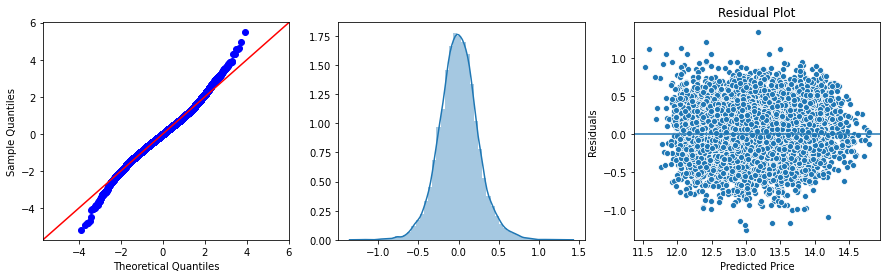

Jarque-Bera     9.118021e+02
Prob           1.010857e-198
Skew            7.948115e-02
Kurtosis        4.001490e+00
dtype: float64


None

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(price)   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                 1.043e+04
Date:                Mon, 18 Jan 2021   Prob (F-statistic):               0.00
Time:                        16:32:47   Log-Likelihood:                -134.70
No. Observations:               21282   AIC:                             285.4
Df Residuals:                   21274   BIC:                             349.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        7.4961      0.044    171.719      0.000       7.411       7.582
np.log(baths_per_sqft)           0.0470      0.007      7.152      0.000       0.034       0.060
view                             0.0710      0.002     28.720      0.000       0.066       0.076
waterfront                       0.4605      0.023     19.897      0.000       0.415       0.506
yr_renovated                  2.469e-05   4.65e-06      5.309      0.000    1.56e-05    3.38e-05
np.log(sqft_living):zipcat_1     0.7285      0.005    159.572      0.000       0.720       0.737
np.log(sqft_living):zipcat_2     0.7788      0.005    171.609      0.000       0.770       0.788
np.log(sqft_living):zipcat_3     0.8203      0.005    179.466      0.000       0.811       0.829
==============================================================================
Omnibus:                      435.798   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              911.802
Skew:                           0.079   Prob(JB):                    1.01e-198
Kurtosis:                       4.001   Cond. No.                     9.71e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.71e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

{'r2': 0.774,
 'train_rmse': 167060.0,
 'test_rmse': 167431.0,
 'diff_rmse': 370.0}

In [118]:
f = '''
np.log(price) ~
np.log(baths_per_sqft)
+ view 
+ waterfront 
+ yr_renovated 
+ np.log(sqft_living):zipcat_1 
+ np.log(sqft_living):zipcat_2
+ np.log(sqft_living):zipcat_3
'''
model_baths = ols(f, df7).fit()

y, X = patsy.dmatrices(f, df7, return_type='dataframe')
model = sm.OLS(y, X).fit()
display(visualize_assumptions(model, X))

# check and save model stats
quicktest(X, y, name='Final model 3: Bathrooms Effect', delog_rmse=True)

Similar to the model above, this model can be used to understand the value of changing the number of bathrooms in the existing footprint of the house.  If more square footage were added additional calculations would be necessary.

The coefficient of the variable `np.log(baths_per_sqft)` is $0.0470$.

Because both the dependent and independent variable are log transformed we take the proportion of $Baths_2$ to $Baths_1$ to the power of the coefficient.

$$ \left( \frac{\textbf{Baths/sqft}_2}{\textbf{Baths/sqft}_1} \right) ^ {0.0470} = 
 \left( \frac{\textbf{Baths}_2}{\textbf{Baths}_1} \right) ^ {0.0470}
 = \textbf{Effect on housing price}$$


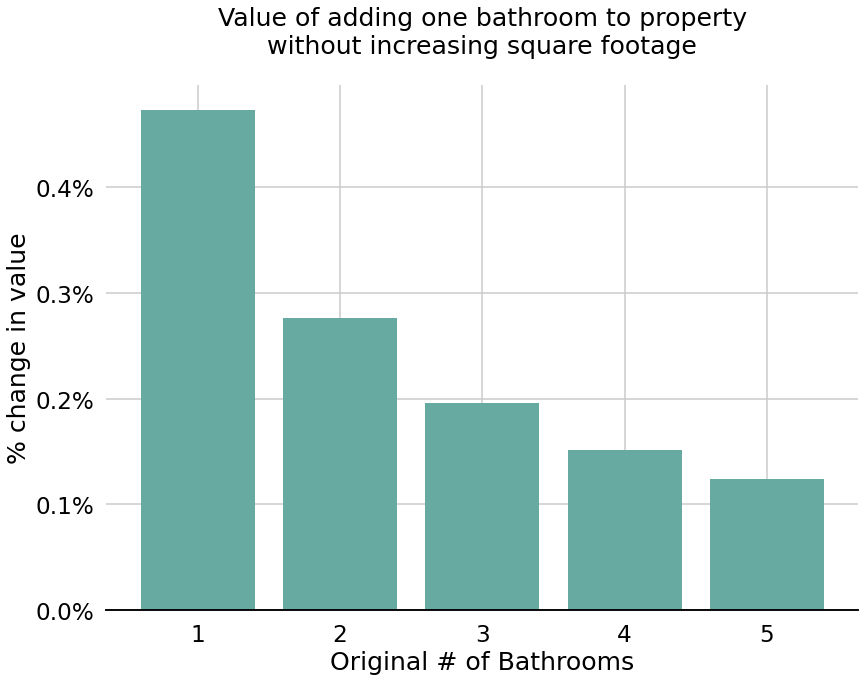

In [119]:
# Number of possible starting bathrooms
baths = np.arange(1,6,1)

# percent change in home price for adding one bathroom
percent_change = ((baths+1)/baths) ** 0.0068 -1

with plt.style.context('fivethirtyeight'), sns.plotting_context("talk", font_scale=1.4):
    
    # plot
    fig = plt.figure(figsize = (12,9))
    plt.bar(baths, percent_change, color='#66aaa2')
    
    # get current axis
    ax = plt.gca()
    
    # format y ticks
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(1, decimals=1))

    # Labels
    plt.title('Value of adding one bathroom to property\nwithout increasing square footage')
    plt.xlabel('Original # of Bathrooms')
    plt.ylabel('% change in value')
        
    # Formatting
    
    # make transparent
    fig.set_facecolor('None')
    ax.set_facecolor('None')
    
    # hide ticks
    ax.tick_params(axis='both', bottom=False, left=False)
    
    # add space below the title
    ax.title.set_position([.5, 1.05])
    
    # remove spines
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # add back bottom spine
    ax.spines['bottom'].set_visible(True)
    ax.spines['bottom'].set_color('black')

# Final Model list

In [120]:
model_report()

r2  train_rmse  \
baseline                                            0.700    201245.0   
1 (nonlinear feature and outlier removal)           0.702    178838.0   
2 (bed/sqft and bath/sqft)                          0.712    174544.0   
3 (zipcode cats)                                    0.771    155469.0   
4 (zip sqft interaction)                            0.779    152742.0   
5.1 (baths_per_sqft)                                0.746    163786.0   
5.2 (beds_per_sqft)                                 0.746    163967.0   
Final Model 1: Price prediction and value estim...  0.778    165560.0   
Final 2: Bedroom Effect                             0.777    165853.0   
Final model 3: Bathrooms Effect                     0.774    167060.0   

                                                    test_rmse  diff_rmse  
baseline                                             202880.0     1635.0  
1 (nonlinear feature and outlier removal)            180363.0     1525.0  
2 (bed/sqft and bath/sqft)                           175974.0     1431.0  
3 (zipcode cats)                                     156164.0      696.0  
4 (zip sqft interaction)                             153048.0      306.0  
5.1 (baths_per_sqft)                                 164198.0      412.0  
5.2 (beds_per_sqft)                                  164370.0      403.0  
Final Model 1: Price prediction and value estim...   165928.0      368.0  
Final 2: Bedroom Effect                              166231.0      378.0  
Final model 3: Bathrooms Effect                      167431.0      370.0

# Assessment, Summary & Recommendations

* Adding square footage to a property can add significant value to a house.

* Adding bedrooms or bathrooms within the existing square footage is likely to result in a loss.

* The model can be used to predict a price although the model is not terribly accurate.  Still the results can be used for understanding a properties relationship to the market.

The models here focus on isolating factors for accurate coefficients rather than on precise prediction.  For price prediction we would not need to be worried about the accuracy of the coefficients so correlations wouldn't need to be removed.  That would allow us to use more data for a more accurate prediction.

This model will not predict the future.  With only 13 months of data we cannot asses overall market trends or even understand if the monthly trends are specific to this year or can be generalized form year to year.

# Further Work

Other areas to explore in this data for the real estate developer are:

1. **Condition** how does price change with condition rating.
2. **Addition Type** Determine the value of different types of expansions (Bedroom, Bathroom, Other)
3. **Improve the model** With more data, or even just a different focus the prediction quality of the model could be improved dramatically.

# Presentation

A pdf of the presentation related to this notebook can be found here: [Presentation](Presentation.pdf).